In [1]:
#%% Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from networkx import DiGraph
import networkx as nx
import statistics
from itertools import permutations
from itertools import combinations #no longer being used
from IPython import display

In [2]:
curated = pd.read_csv('curated_gene_disease_associations.tsv', sep = "\t")
curated

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.700,0.538,C0019209,Hepatomegaly,phenotype,C23;C06,Finding,0.30,1.000,2017.0,2017.0,1,0,CTD_human
1,1,A1BG,0.700,0.538,C0036341,Schizophrenia,disease,F03,Mental or Behavioral Dysfunction,0.30,1.000,2015.0,2015.0,1,0,CTD_human
2,2,A2M,0.529,0.769,C0002395,Alzheimer's Disease,disease,C10;F03,Disease or Syndrome,0.50,0.769,1998.0,2018.0,3,0,CTD_human
3,2,A2M,0.529,0.769,C0007102,Malignant tumor of colon,disease,C06;C04,Neoplastic Process,0.31,1.000,2004.0,2019.0,1,0,CTD_human
4,2,A2M,0.529,0.769,C0009375,Colonic Neoplasms,group,C06;C04,Neoplastic Process,0.30,1.000,2004.0,2004.0,1,0,CTD_human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84033,109580095,HBB-LCR,0.743,0.115,C0002875,Cooley's anemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84034,109580095,HBB-LCR,0.743,0.115,C0005283,beta Thalassemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84035,109580095,HBB-LCR,0.743,0.115,C0019025,Hemoglobin F Disease,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84036,109580095,HBB-LCR,0.743,0.115,C0085578,Thalassemia Minor,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human


In [3]:
threeCol = curated.drop(columns = ['diseaseType', 'DSI', 'DPI', 'diseaseClass', 'diseaseSemanticType', 'score', 'EI', 'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps'])
threeCol

,geneId,geneSymbol,diseaseId,diseaseName,source
0,1,A1BG,C0019209,Hepatomegaly,CTD_human
1,1,A1BG,C0036341,Schizophrenia,CTD_human
2,2,A2M,C0002395,Alzheimer's Disease,CTD_human
3,2,A2M,C0007102,Malignant tumor of colon,CTD_human
4,2,A2M,C0009375,Colonic Neoplasms,CTD_human
...,...,...,...,...,...
84033,109580095,HBB-LCR,C0002875,Cooley's anemia,CTD_human
84034,109580095,HBB-LCR,C0005283,beta Thalassemia,CTD_human
84035,109580095,HBB-LCR,C0019025,Hemoglobin F Disease,CTD_human
84036,109580095,HBB-LCR,C0085578,Thalassemia Minor,CTD_human


In [4]:
threeCol['source'] = threeCol['source'].apply(lambda x: set(x[:].split(";")))
threeColsep = pd.DataFrame([(c, tup.geneId, tup.geneSymbol, tup.diseaseId, tup.diseaseName) for tup in threeCol.itertuples() for c in tup.source])
threeColsep = threeColsep.rename(columns= {0: 'source', 1: 'geneId', 2: 'geneSymbol', 3: 'diseaseId', 4: 'diseaseName'})
threeColsep

,source,geneId,geneSymbol,diseaseId,diseaseName
0,CTD_human,1,A1BG,C0019209,Hepatomegaly
1,CTD_human,1,A1BG,C0036341,Schizophrenia
2,CTD_human,2,A2M,C0002395,Alzheimer's Disease
3,CTD_human,2,A2M,C0007102,Malignant tumor of colon
4,CTD_human,2,A2M,C0009375,Colonic Neoplasms
...,...,...,...,...,...
96920,CTD_human,109580095,HBB-LCR,C0002875,Cooley's anemia
96921,CTD_human,109580095,HBB-LCR,C0005283,beta Thalassemia
96922,CTD_human,109580095,HBB-LCR,C0019025,Hemoglobin F Disease
96923,CTD_human,109580095,HBB-LCR,C0085578,Thalassemia Minor


In [5]:
diseasemappings = pd.read_csv('disease_mappings.tsv', sep = '\t')
diseasemappings

,diseaseId,name,vocabulary,code,vocabularyName
0,C0018923,Hemangiosarcoma,DO,0001816,angiosarcoma
1,C0854893,Angiosarcoma non-metastatic,DO,0001816,angiosarcoma
2,C0033999,Pterygium,DO,0002116,pterygium
3,C0025517,Metabolic Diseases,DO,0014667,disease of metabolism
4,C0155862,Streptococcal pneumonia,DO,0040084,Streptococcus pneumonia
...,...,...,...,...,...
242884,C0279628,Adenocarcinoma Of Esophagus,ORDO,99976,Adenocarcinoma of the esophagus
242885,C0279626,Squamous cell carcinoma of esophagus,ORDO,99977,Squamous cell carcinoma of the esophagus
242886,C0206702,Klatskin Tumor,ORDO,99978,Klatskin tumor
242887,C0007462,Causalgia,ORDO,99994,Complex regional pain syndrome type 2


In [6]:
diseasemappings = diseasemappings.drop(columns = ['vocabularyName'])
diseasemappings = diseasemappings.rename(columns = {'name': 'diseaseName'})
diseasemappings

,diseaseId,diseaseName,vocabulary,code
0,C0018923,Hemangiosarcoma,DO,0001816
1,C0854893,Angiosarcoma non-metastatic,DO,0001816
2,C0033999,Pterygium,DO,0002116
3,C0025517,Metabolic Diseases,DO,0014667
4,C0155862,Streptococcal pneumonia,DO,0040084
...,...,...,...,...
242884,C0279628,Adenocarcinoma Of Esophagus,ORDO,99976
242885,C0279626,Squamous cell carcinoma of esophagus,ORDO,99977
242886,C0206702,Klatskin Tumor,ORDO,99978
242887,C0007462,Causalgia,ORDO,99994


In [7]:
result1 = diseasemappings.merge(threeColsep)
result2 = result1[result1['vocabulary'].map(lambda d: d == 'DO')]
result2['DOID'] = ('DOID:' + (result2['code']))
result2

<ipython-input-7-ecb85bb04ea3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result2['DOID'] = ('DOID:' + (result2['code']))


,diseaseId,diseaseName,vocabulary,code,source,geneId,geneSymbol,DOID
0,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,285,ANGPT2,DOID:0001816
1,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,595,CCND1,DOID:0001816
2,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1440,CSF3,DOID:0001816
3,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1499,CTNNB1,DOID:0001816
4,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,2321,FLT1,DOID:0001816
...,...,...,...,...,...,...,...,...
3230992,C0020615,Hypoglycemia,DO,9993,CTD_human,5465,PPARA,DOID:9993
3230993,C0020615,Hypoglycemia,DO,9993,CTD_human,6648,SOD2,DOID:9993
3230994,C0020615,Hypoglycemia,DO,9993,CTD_human,6927,HNF1A,DOID:9993
3230995,C0020615,Hypoglycemia,DO,9993,CTD_human,7124,TNF,DOID:9993


In [8]:
resultDOID = result2.groupby(by = ['DOID', 'diseaseName', 'source'])['geneId'].apply(lambda x: set(x))
resultDOID = resultDOID.reset_index()
resultDOID

,DOID,diseaseName,source,geneId
0,DOID:0001816,Hemangiosarcoma,CGI,"{5335, 5787, 3845, 3791}"
1,DOID:0001816,Hemangiosarcoma,CTD_human,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372..."
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
4,DOID:0014667,Metabolic Diseases,CTD_human,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [9]:
from imp import reload
import ontology
reload(ontology)

<module 'ontology' from '/mnt/ufs18/home-087/f0102402/Arun_REU/ontology.py'>

In [10]:
from ontology import Ontology

In [11]:
disease_ontology = ontology.Ontology()
disease_ontology.load("/mnt/research/compbio/krishnanlab/data/ontologies/doid.obo")

In [12]:
resultDOIDshort = resultDOID.drop(columns = 'diseaseName')
dict_of_sources = dict(iter(resultDOIDshort.groupby('source')))
dict_of_sources['CLINGEN']

,DOID,source,geneId
49,DOID:0050332,CLINGEN,"{2299, 3766}"
78,DOID:0050428,CLINGEN,{362}
103,DOID:0050429,CLINGEN,{9401}
130,DOID:0050437,CLINGEN,{3920}
141,DOID:0050439,CLINGEN,{25861}
...,...,...,...
19658,DOID:9274,CLINGEN,{2639}
19664,DOID:9274,CLINGEN,{10157}
19676,DOID:9278,CLINGEN,{383}
19681,DOID:9280,CLINGEN,{1373}


In [13]:
CLINGEN_dict = dict(zip(dict_of_sources['CLINGEN'].DOID, dict_of_sources['CLINGEN'].geneId))
CTD_human_dict = dict(zip(dict_of_sources['CTD_human'].DOID, dict_of_sources['CTD_human'].geneId))
CGI_dict = dict(zip(dict_of_sources['CGI'].DOID, dict_of_sources['CGI'].geneId))
GENOMICS_ENGLAND_dict = dict(zip(dict_of_sources['GENOMICS_ENGLAND'].DOID, dict_of_sources['GENOMICS_ENGLAND'].geneId))
UNIPROT_dict = dict(zip(dict_of_sources['UNIPROT'].DOID, dict_of_sources['UNIPROT'].geneId))
ORPHANET_dict = dict(zip(dict_of_sources['ORPHANET'].DOID, dict_of_sources['ORPHANET'].geneId))
PSYGENET_dict = dict(zip(dict_of_sources['PSYGENET'].DOID, dict_of_sources['PSYGENET'].geneId))

In [14]:
CLINGEN_prop = disease_ontology.propagate(CLINGEN_dict)
CTD_human_prop = disease_ontology.propagate(CTD_human_dict)
CGI_prop = disease_ontology.propagate(CGI_dict)
GENOMICS_ENGLAND_prop = disease_ontology.propagate(GENOMICS_ENGLAND_dict)
UNIPROT_prop = disease_ontology.propagate(UNIPROT_dict)
ORPHANET_prop = disease_ontology.propagate(ORPHANET_dict)
PSYGENET_prop = disease_ontology.propagate(PSYGENET_dict)

In [15]:
CLINGEN = pd.DataFrame([k for k in CLINGEN_prop.items()], columns=['DOID', 'geneSet'])
CTD_human = pd.DataFrame([k for k in CTD_human_prop.items()], columns=['DOID', 'geneSet'])
CGI = pd.DataFrame([k for k in CGI_prop.items()], columns=['DOID', 'geneSet'])
GENOMICS_ENGLAND = pd.DataFrame([k for k in GENOMICS_ENGLAND_prop.items()], columns=['DOID', 'geneSet'])
ORPHANET = pd.DataFrame([k for k in ORPHANET_prop.items()], columns=['DOID', 'geneSet'])
UNIPROT = pd.DataFrame([k for k in UNIPROT_prop.items()], columns=['DOID', 'geneSet'])
PSYGENET = pd.DataFrame([k for k in PSYGENET_prop.items()], columns=['DOID', 'geneSet'])

In [16]:
CLINGEN['source'] = 'CLINGEN'
CTD_human['source'] = 'CTD_human'
CGI['source'] = 'CGI'
GENOMICS_ENGLAND['source'] = 'GENOMICS_ENGLAND'
ORPHANET['source'] = 'ORPHANET'
UNIPROT['source'] = 'UNIPROT'
PSYGENET['source'] = 'PSYGENET'

In [17]:
propagated = CLINGEN.append(CTD_human).append(CGI).append(GENOMICS_ENGLAND).append(ORPHANET).append(UNIPROT).append(PSYGENET)
propagated

,DOID,geneSet,source
0,DOID:0050332,"{2299, 3766}",CLINGEN
1,DOID:3426,"{2299, 3766}",CLINGEN
2,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN
3,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN
4,DOID:2952,"{2299, 3766}",CLINGEN
...,...,...,...
44,DOID:809,"{4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...",PSYGENET
45,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET
46,DOID:9478,"{8864, 6532, 3350, 4988, 50809, 4524, 148014}",PSYGENET
47,DOID:9505,"{6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...",PSYGENET


In [18]:
templist = []
for index, row, in propagated.iterrows():
    if (row['DOID'] in disease_ontology.nodes):
        templist.append(disease_ontology.nodes[row['DOID']]["name"])
    else:
        templist.append("error")
propagated['diseaseName'] = templist
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:3426,"{2299, 3766}",CLINGEN,vestibular disease
2,DOID:0050155,"{65217, 25861, 64072, 4043, 22926, 4942, 23568...",CLINGEN,sensory system disease
3,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN,disease
4,DOID:2952,"{2299, 3766}",CLINGEN,inner ear disease
...,...,...,...,...
44,DOID:809,"{4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...",PSYGENET,cocaine abuse
45,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET,subacute delirium
46,DOID:9478,"{8864, 6532, 3350, 4988, 50809, 4524, 148014}",PSYGENET,postpartum depression
47,DOID:9505,"{6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...",PSYGENET,cannabis abuse


In [20]:
selected = pd.read_csv('selectedDOIDS.csv')
selected

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10
0,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6
1,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206,6
2,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987,5
3,DOID:3119,gastrointestinal system cancer,3,76,993,29,17,0,528,6,1463,5
4,DOID:305,carcinoma,2,112,1087,36,36,0,211,166,1310,5
...,...,...,...,...,...,...,...,...,...,...,...,...
72,DOID:1342,congenital hypoplastic anemia,9,0,25,54,20,0,14,32,60,4
73,DOID:1793,pancreatic cancer,0,17,28,2,8,0,15,107,58,3
74,DOID:628,combined T cell and B cell immunodeficiency,1,0,24,28,26,0,16,42,38,4
75,DOID:0110274,autosomal recessive limb-girdle muscular dystr...,0,0,12,23,9,0,20,8,30,3


In [21]:
selected = selected.rename(columns = {'dis_doid': 'DOID'})
selected

,DOID,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10
0,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6
1,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206,6
2,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987,5
3,DOID:3119,gastrointestinal system cancer,3,76,993,29,17,0,528,6,1463,5
4,DOID:305,carcinoma,2,112,1087,36,36,0,211,166,1310,5
...,...,...,...,...,...,...,...,...,...,...,...,...
72,DOID:1342,congenital hypoplastic anemia,9,0,25,54,20,0,14,32,60,4
73,DOID:1793,pancreatic cancer,0,17,28,2,8,0,15,107,58,3
74,DOID:628,combined T cell and B cell immunodeficiency,1,0,24,28,26,0,16,42,38,4
75,DOID:0110274,autosomal recessive limb-girdle muscular dystr...,0,0,12,23,9,0,20,8,30,3


In [26]:
result = selected.merge(propagated, how = 'inner')
result

,DOID,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10,geneSet,source,diseaseName
0,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{11200, 5889, 5892, 580, 4292, 6598, 7046, 436...",CLINGEN,cancer
1,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{2, 9, 10, 100499467, 8202, 12, 8204, 10004891...",CTD_human,cancer
2,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{2048, 1026, 1027, 7172, 1029, 1030, 1031, 171...",CGI,cancer
3,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{1027, 1028, 1029, 54790, 4615, 171023, 5649, ...",GENOMICS_ENGLAND,cancer
4,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{2048, 4609, 7170, 7171, 1029, 54790, 4615, 71...",ORPHANET,cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,DOID:0110274,autosomal recessive limb-girdle muscular dystr...,0,0,12,23,9,0,20,8,30,3,"{729920, 29954, 1605, 55624, 60684, 11149, 203...",UNIPROT,autosomal recessive limb-girdle muscular dystr...
399,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14,3,"{778, 4308, 6295, 60506, 2779, 2784, 9187, 291...",CTD_human,congenital stationary night blindness
400,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14,3,"{9187, 2916, 60506, 5158, 345193, 778, 440435,...",GENOMICS_ENGLAND,congenital stationary night blindness
401,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14,3,"{6011, 6295}",ORPHANET,congenital stationary night blindness


In [27]:
# Creating Sets of Sources Based on Disease
a2 = result.groupby(by = ['DOID'])['source'].apply(lambda x: set(x))
a2 = a2.to_frame().reset_index()
a2

,DOID,source
0,DOID:0014667,"{CLINGEN, CGI, CTD_human, GENOMICS_ENGLAND, UN..."
1,DOID:0050387,"{CGI, CTD_human, GENOMICS_ENGLAND, UNIPROT, OR..."
2,DOID:0050534,"{ORPHANET, CTD_human, GENOMICS_ENGLAND, UNIPROT}"
3,DOID:0050700,"{CLINGEN, CTD_human, GENOMICS_ENGLAND, UNIPROT..."
4,DOID:0050951,"{CLINGEN, CTD_human, GENOMICS_ENGLAND, UNIPROT..."
...,...,...
72,DOID:9256,"{CGI, CTD_human, GENOMICS_ENGLAND, UNIPROT}"
73,DOID:9351,"{ORPHANET, CTD_human, GENOMICS_ENGLAND, UNIPROT}"
74,DOID:936,"{CLINGEN, CGI, CTD_human, GENOMICS_ENGLAND, UN..."
75,DOID:9455,"{CLINGEN, CTD_human, GENOMICS_ENGLAND, UNIPROT..."


In [28]:
# Creating the Different Possible Combinations of Sources for Each Disease:
from itertools import product
a2['permutations'] = a2['source'].apply(lambda r: list(product(r,repeat = 2)))

# Removing the Diseases that Only Hold One Source:
a3 = a2[a2['permutations'].map(lambda d: len(d)) > 0]
a3

,DOID,source,permutations
0,DOID:0014667,"{CLINGEN, CGI, CTD_human, GENOMICS_ENGLAND, UN...","[(CLINGEN, CLINGEN), (CLINGEN, CGI), (CLINGEN,..."
1,DOID:0050387,"{CGI, CTD_human, GENOMICS_ENGLAND, UNIPROT, OR...","[(CGI, CGI), (CGI, CTD_human), (CGI, GENOMICS_..."
2,DOID:0050534,"{ORPHANET, CTD_human, GENOMICS_ENGLAND, UNIPROT}","[(ORPHANET, ORPHANET), (ORPHANET, CTD_human), ..."
3,DOID:0050700,"{CLINGEN, CTD_human, GENOMICS_ENGLAND, UNIPROT...","[(CLINGEN, CLINGEN), (CLINGEN, CTD_human), (CL..."
4,DOID:0050951,"{CLINGEN, CTD_human, GENOMICS_ENGLAND, UNIPROT...","[(CLINGEN, CLINGEN), (CLINGEN, CTD_human), (CL..."
...,...,...,...
72,DOID:9256,"{CGI, CTD_human, GENOMICS_ENGLAND, UNIPROT}","[(CGI, CGI), (CGI, CTD_human), (CGI, GENOMICS_..."
73,DOID:9351,"{ORPHANET, CTD_human, GENOMICS_ENGLAND, UNIPROT}","[(ORPHANET, ORPHANET), (ORPHANET, CTD_human), ..."
74,DOID:936,"{CLINGEN, CGI, CTD_human, GENOMICS_ENGLAND, UN...","[(CLINGEN, CLINGEN), (CLINGEN, CGI), (CLINGEN,..."
75,DOID:9455,"{CLINGEN, CTD_human, GENOMICS_ENGLAND, UNIPROT...","[(CLINGEN, CLINGEN), (CLINGEN, CTD_human), (CL..."


In [30]:
# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.DOID) for tup in a3.itertuples() for c in tup.permutations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'DOID'})

# Separating the Created Combinations into 2 Columns:
resultGE[['SourceTrain','SourceEval']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)

In [32]:
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = result.loc[(result['DOID'] == row['DOID']) & (result['source'] == row['SourceTrain'])]
    arowList.append(midrow.iloc[0]['geneSet'])
    
    midrow2 = result.loc[(result['DOID'] == row['DOID']) & (result['source'] == row['SourceEval'])]
    arow2List.append(midrow2.iloc[0]['geneSet'])

In [33]:
resultGE['geneId1'] = arowList
resultGE['geneId2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan

In [34]:
# Jaccard Similarity Coefficient/Jaccard Index Function:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [35]:
def f(x):
    return jaccard(x['geneId1'], x['geneId2']) 

In [36]:
resultGE['jaccardIndex'] = resultGE.apply(f, axis = 1)
resultGE

,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex
0,DOID:0014667,CLINGEN,CLINGEN,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{51204, 3081, 9997, 374291, 55572, 275, 55065,...",1.000000
1,DOID:0014667,CLINGEN,CGI,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...",{4615},0.000000
2,DOID:0014667,CLINGEN,CTD_human,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{2, 10243, 51204, 2053, 2055, 2056, 12, 18, 55...",0.069502
3,DOID:0014667,CLINGEN,GENOMICS_ENGLAND,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{644096, 3073, 3074, 10243, 7172, 3077, 378884...",0.173302
4,DOID:0014667,CLINGEN,UNIPROT,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{644096, 1537, 514, 140803, 90624, 3077, 10243...",0.201413
...,...,...,...,...,...,...
2156,DOID:9884,GENOMICS_ENGLAND,UNIPROT,"{7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...","{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...",0.627119
2157,DOID:9884,UNIPROT,ORPHANET,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...","{7169, 1282, 29954, 9987, 1674, 1291, 1292, 12...",0.444444
2158,DOID:9884,UNIPROT,CTD_human,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...","{7169, 29954, 7170, 1281, 1026, 1291, 1292, 12...",0.317647
2159,DOID:9884,UNIPROT,GENOMICS_ENGLAND,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...","{7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...",0.627119


<ipython-input-39-98ba1720c295>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,6))


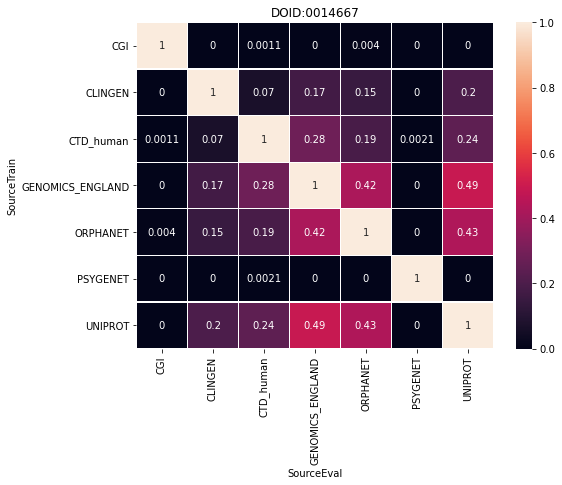

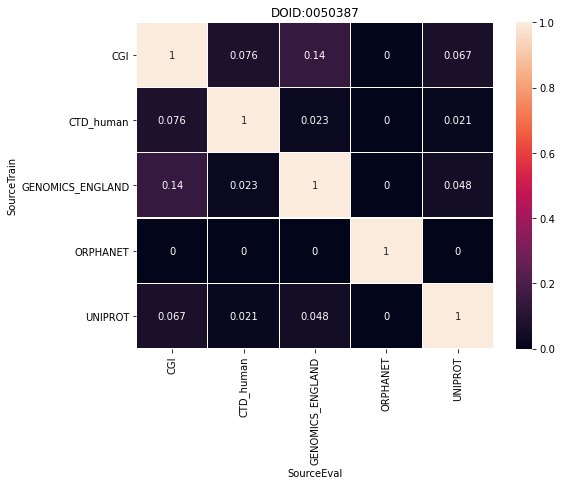

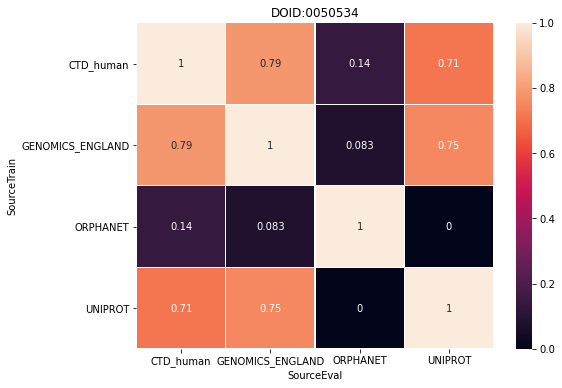

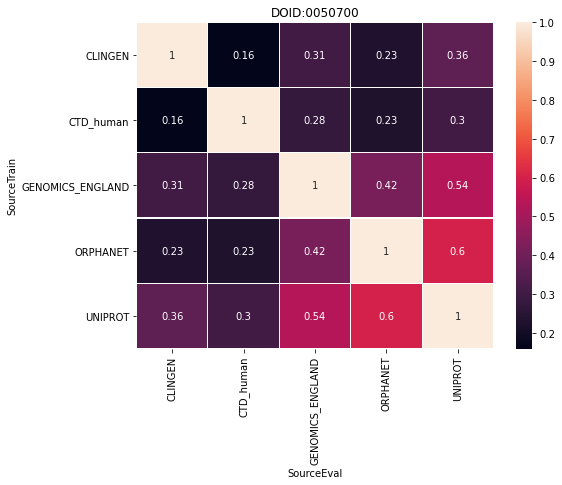

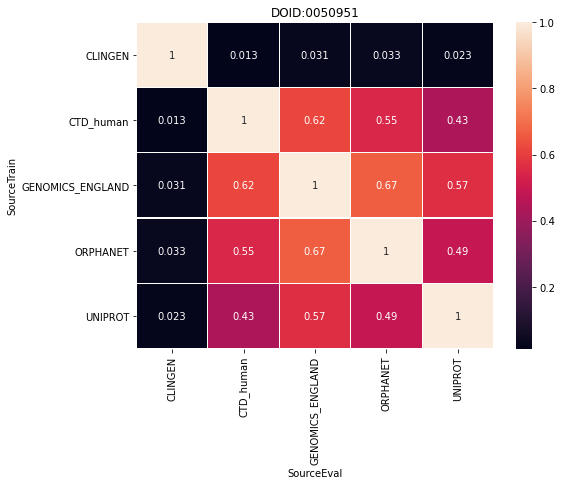

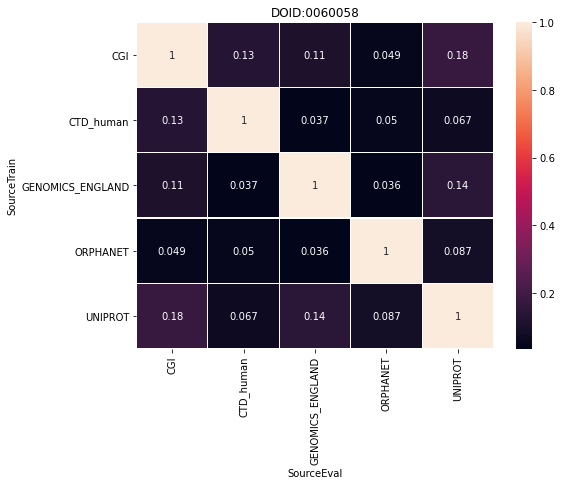

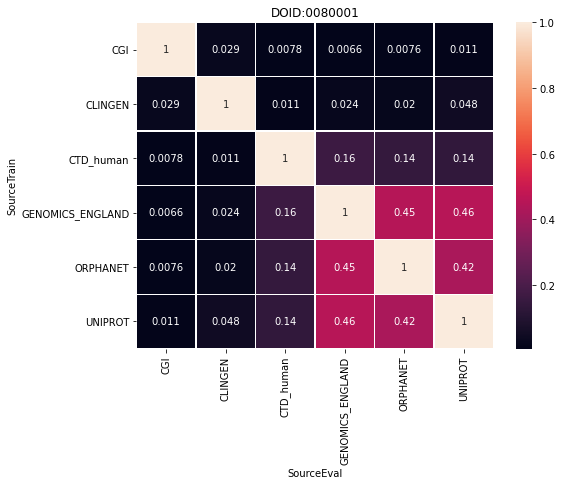

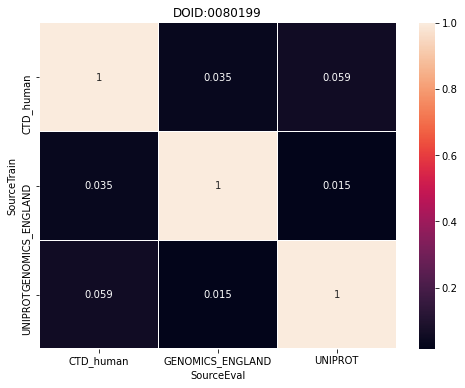

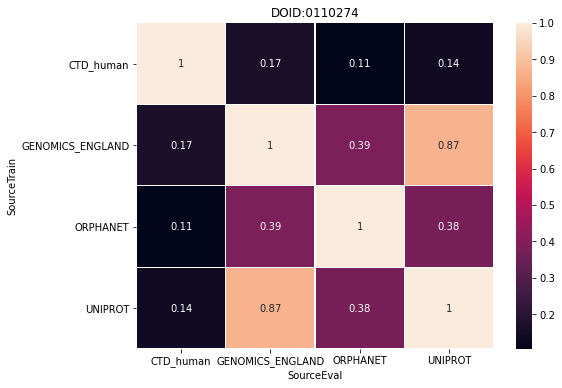

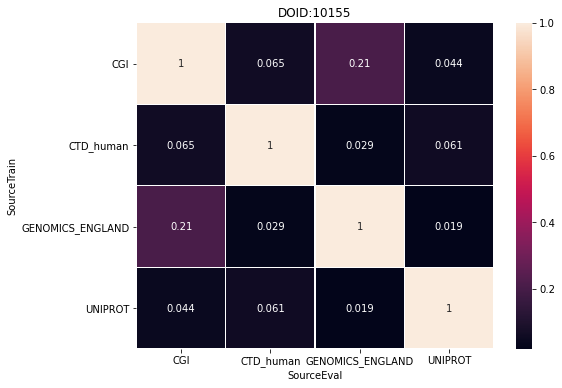

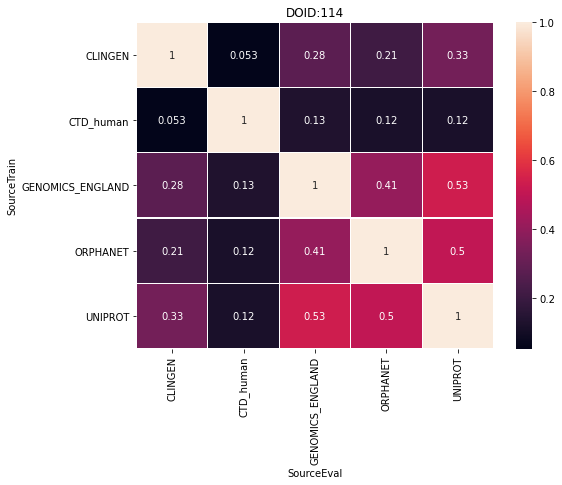

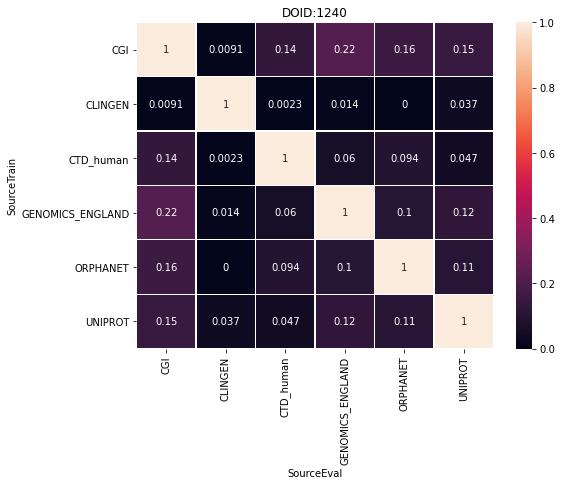

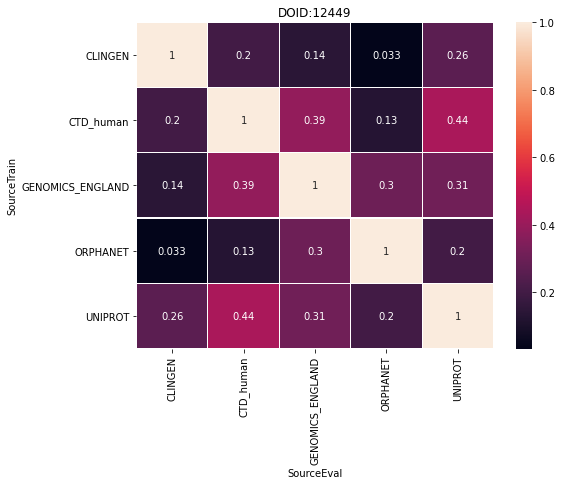

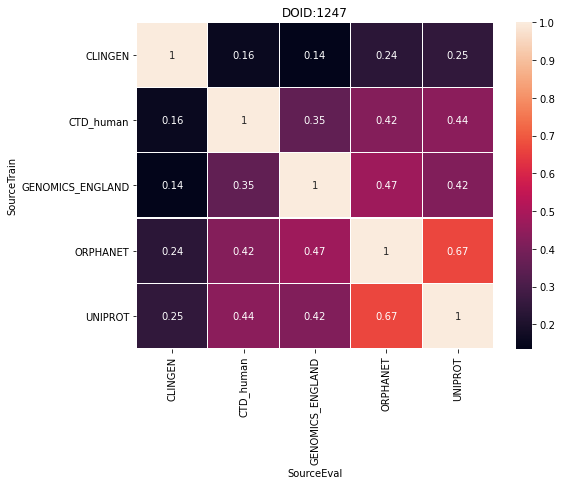

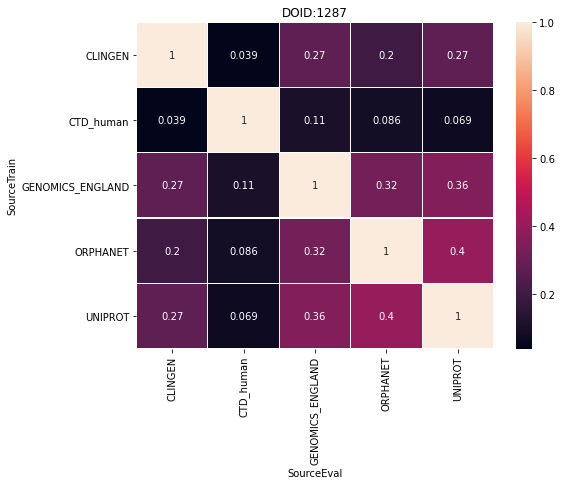

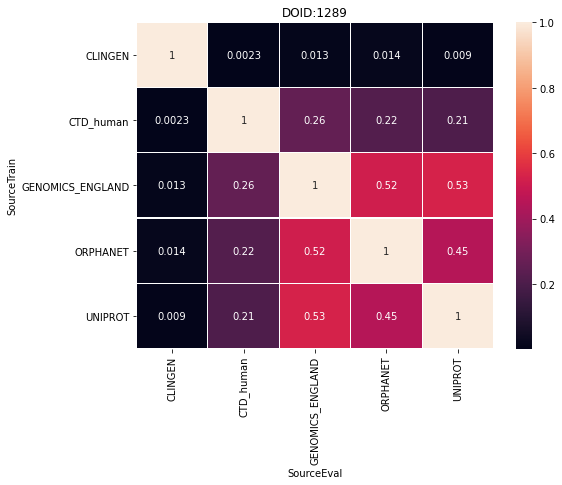

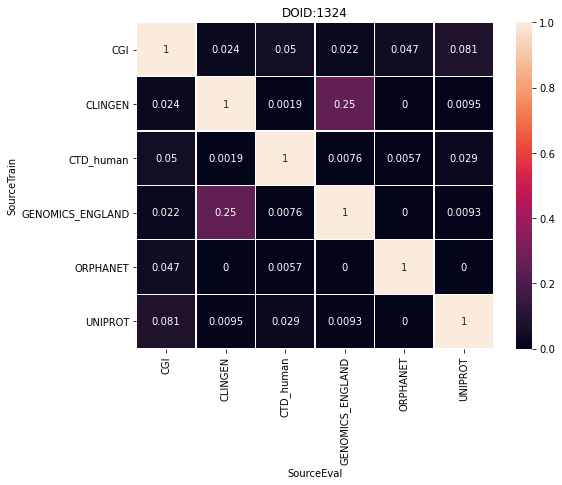

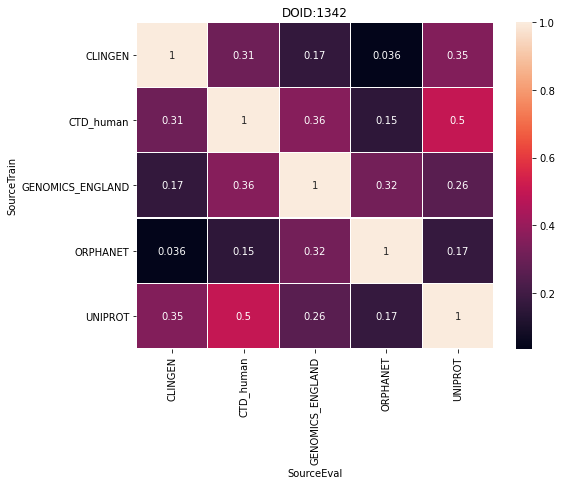

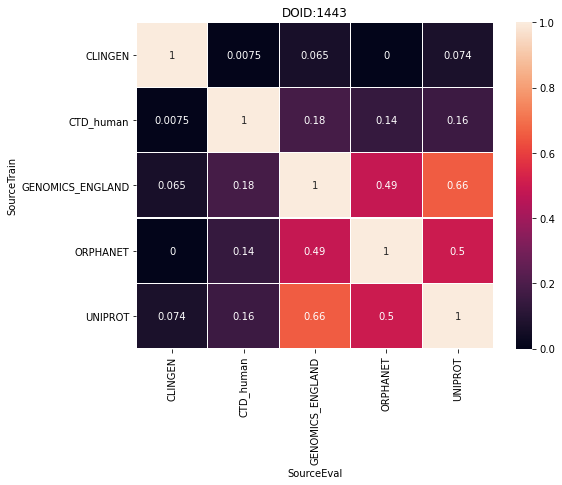

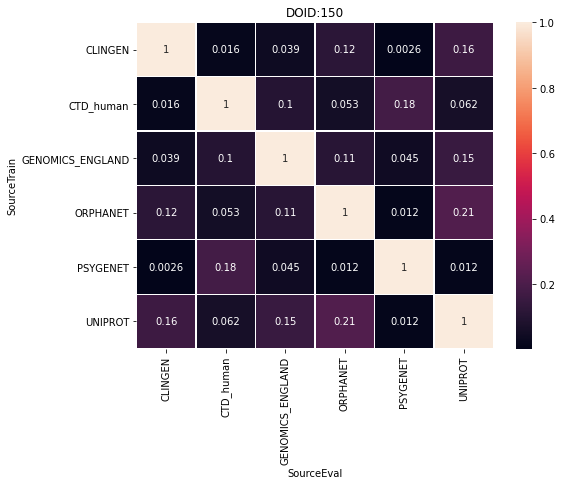

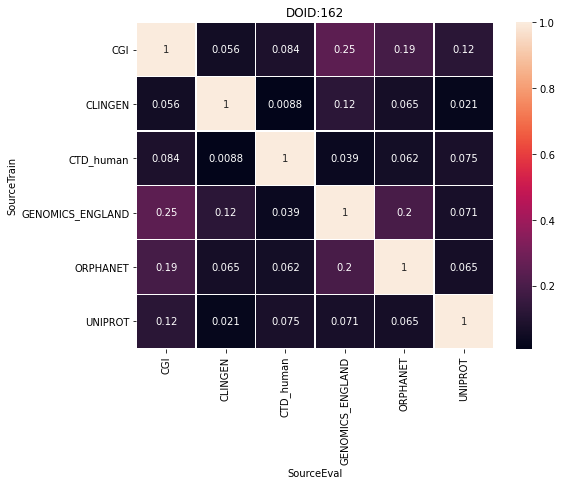

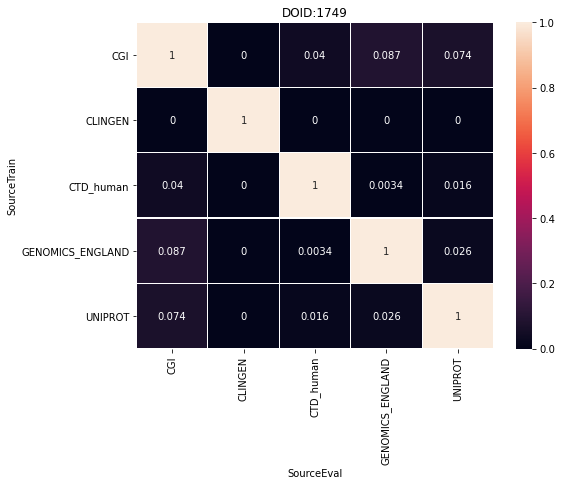

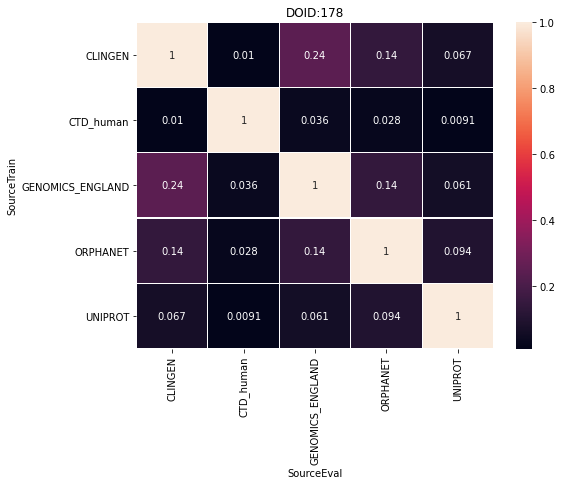

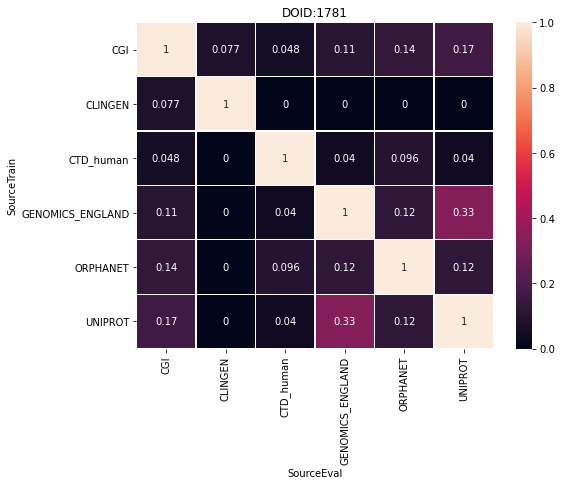

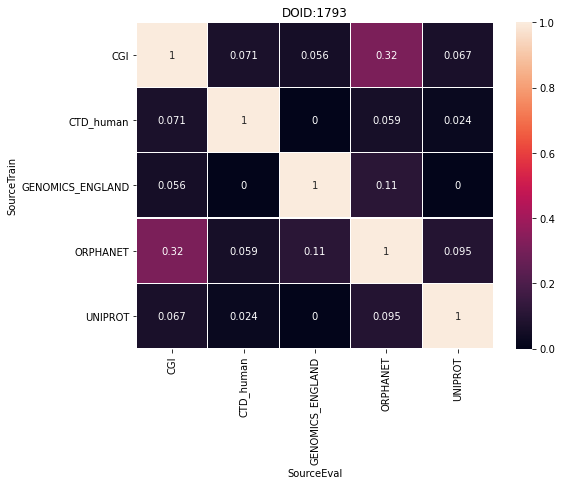

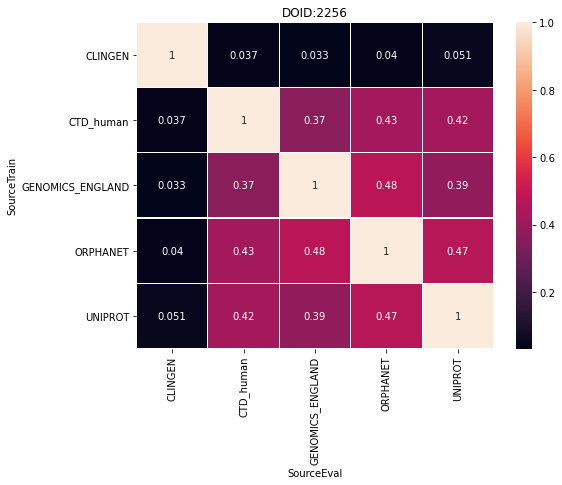

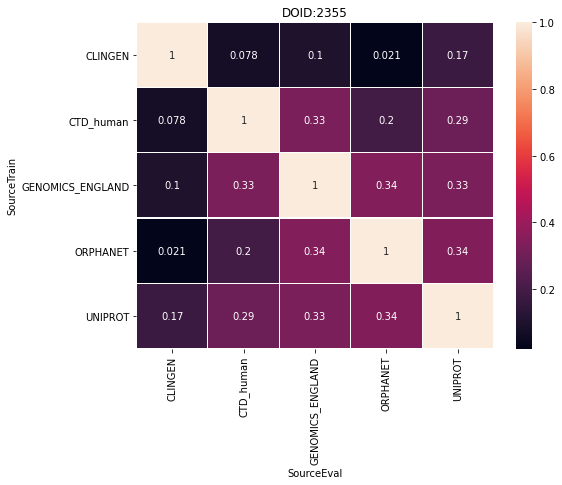

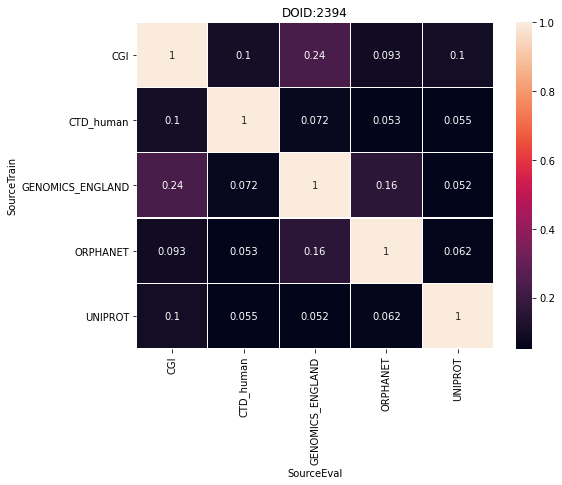

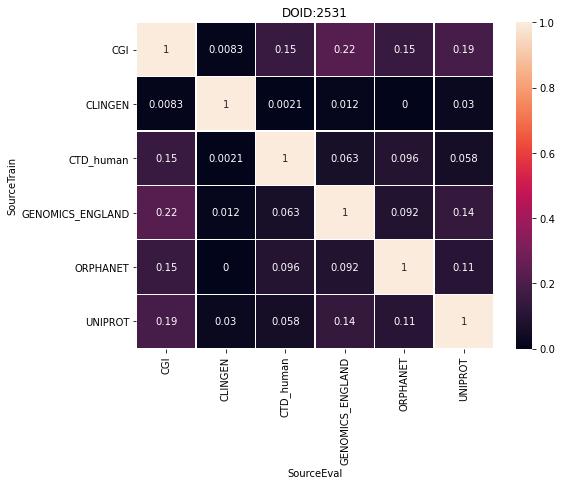

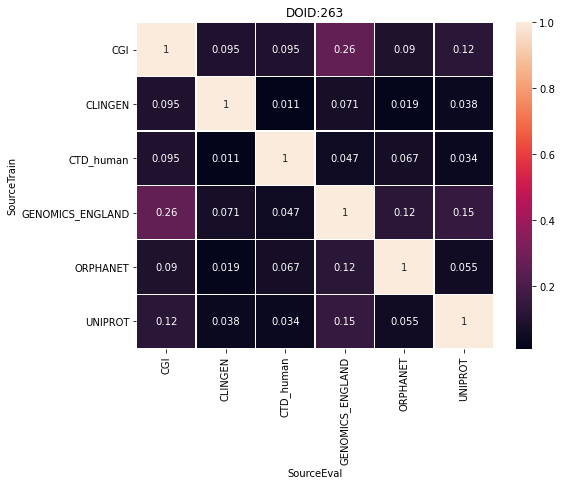

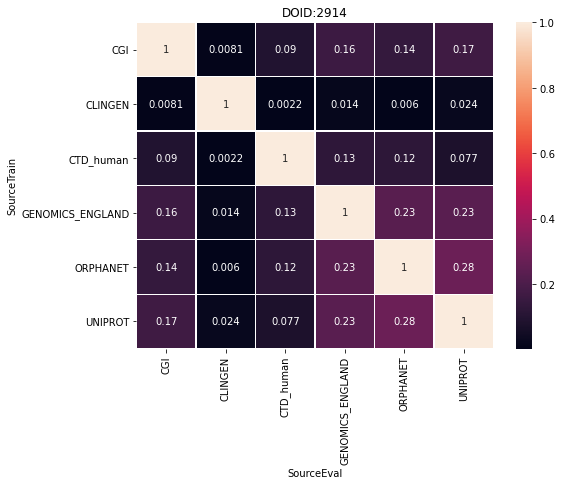

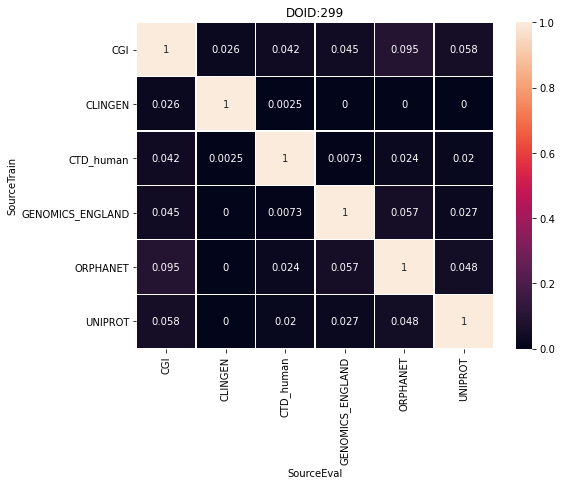

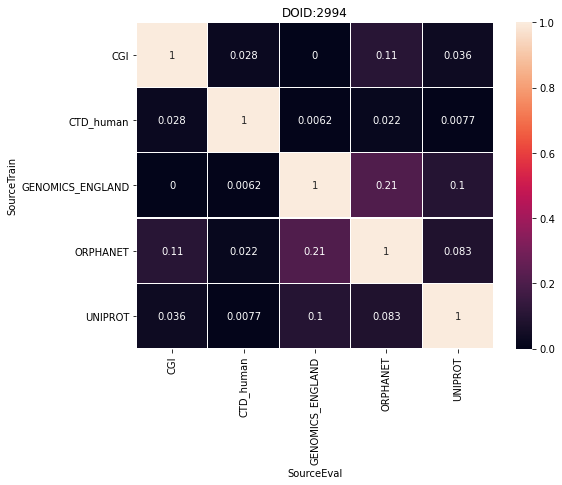

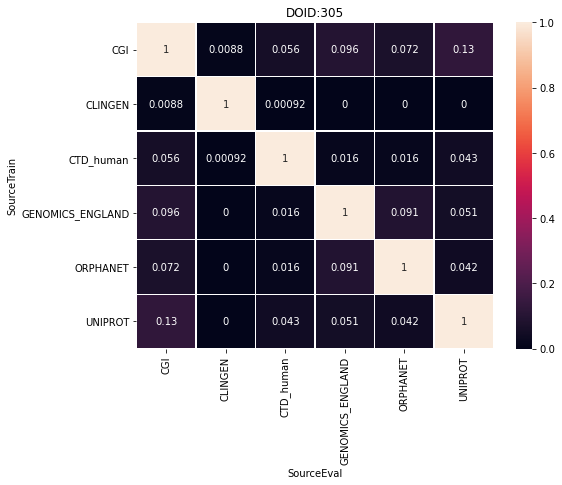

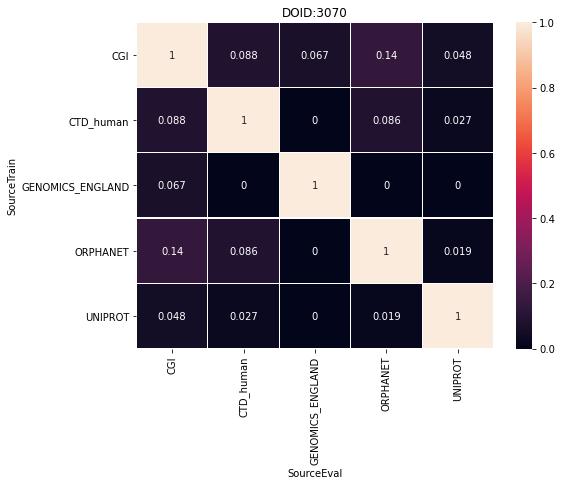

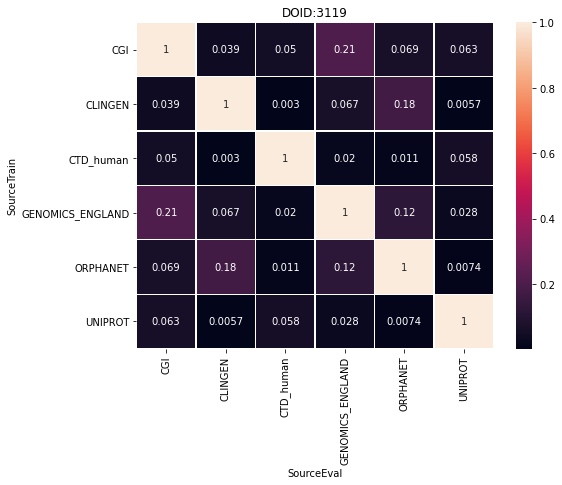

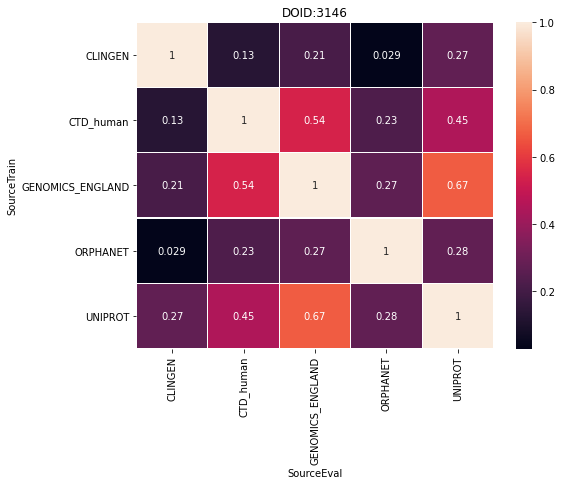

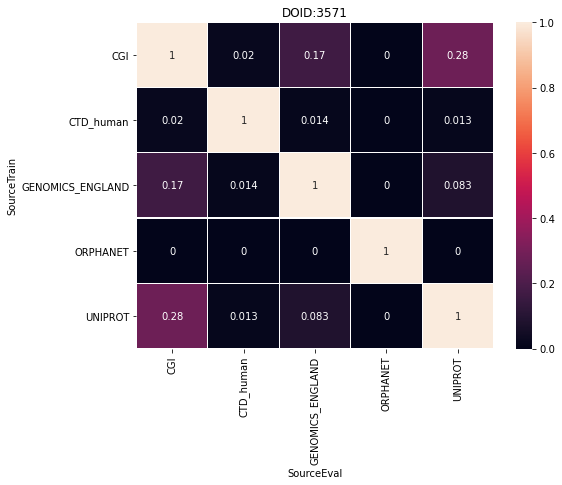

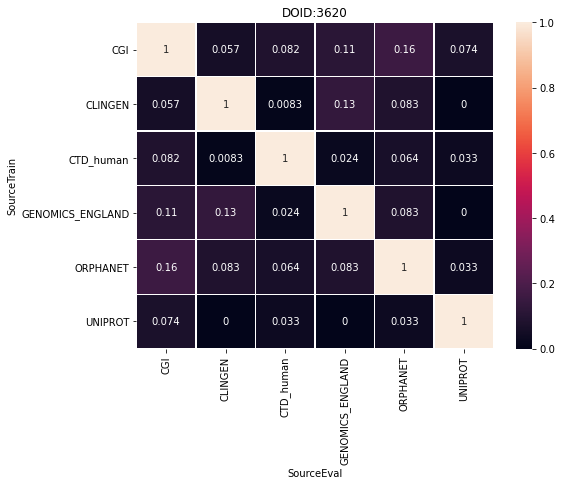

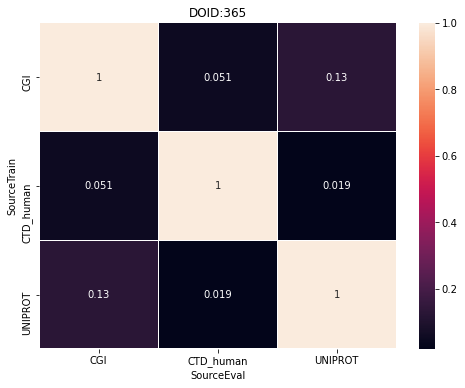

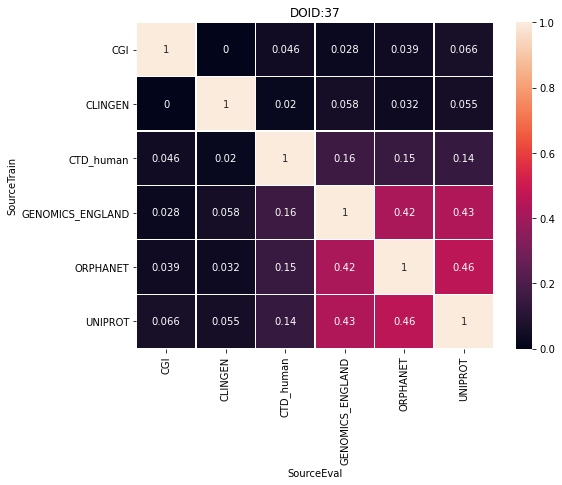

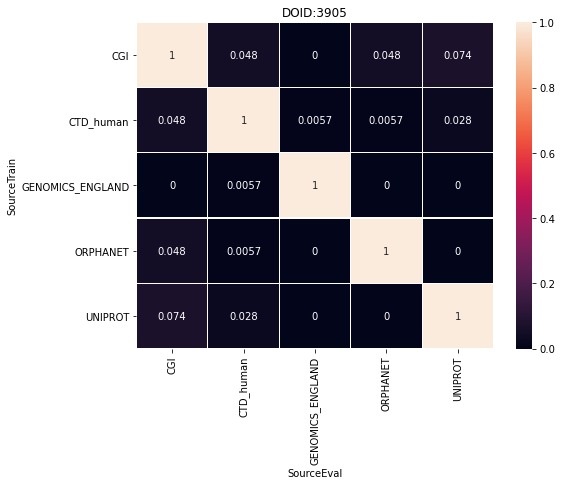

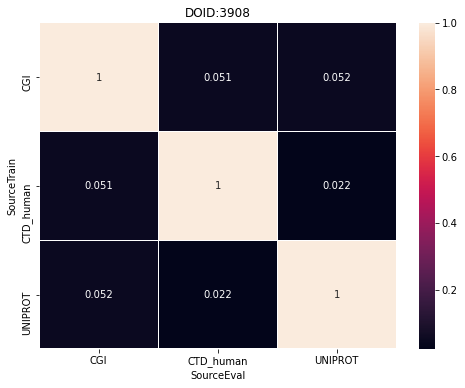

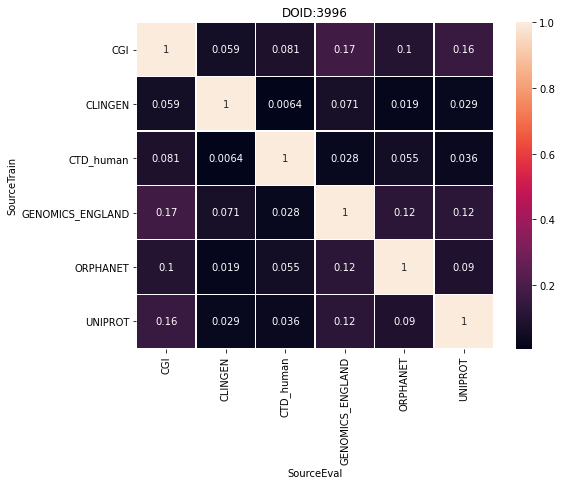

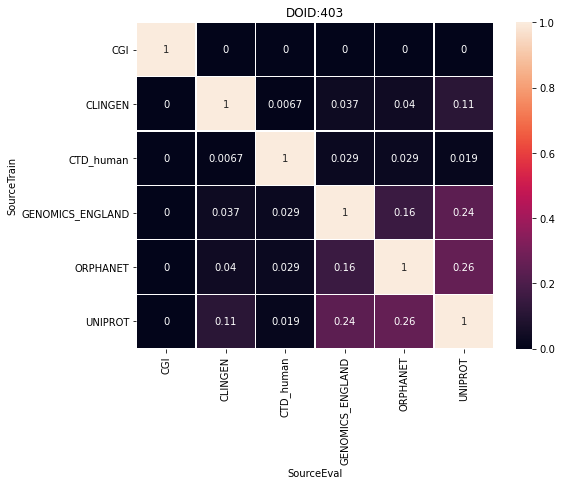

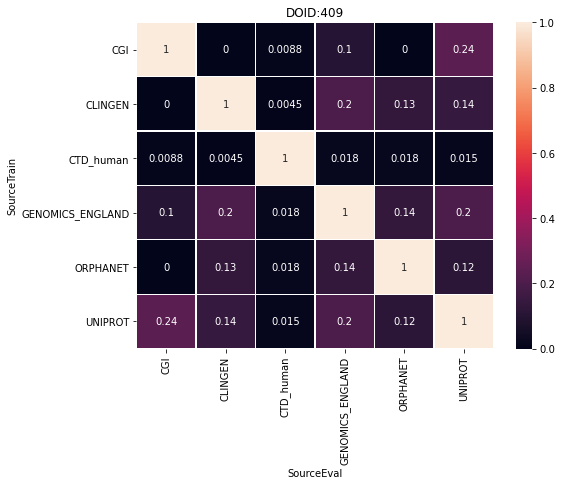

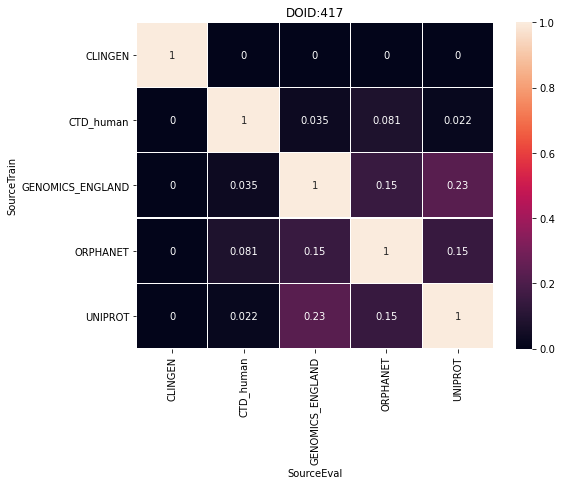

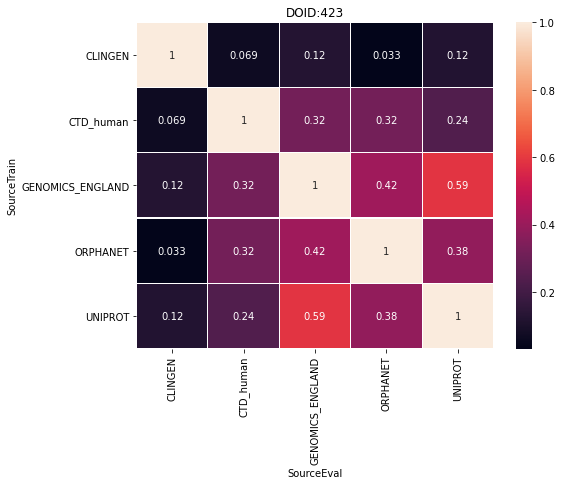

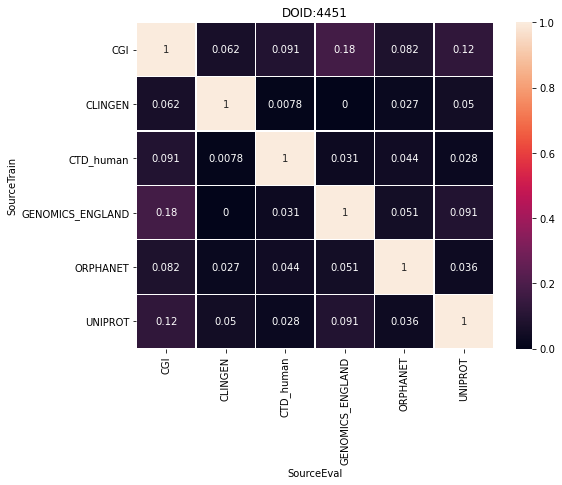

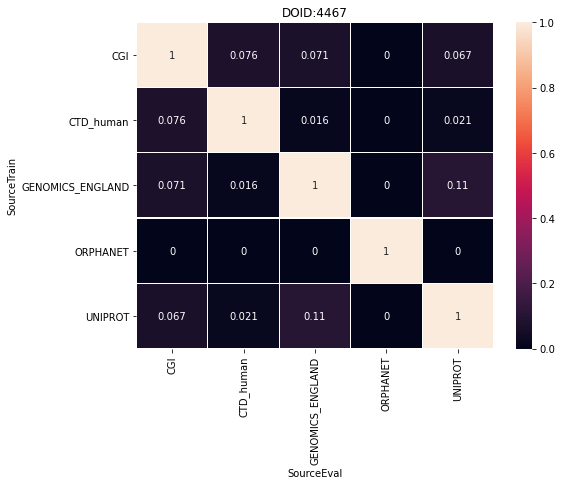

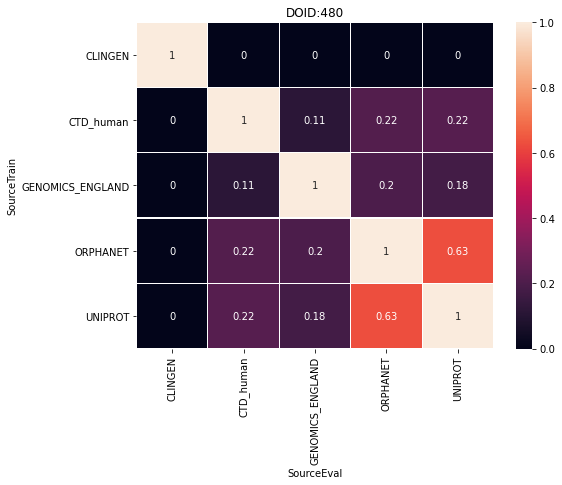

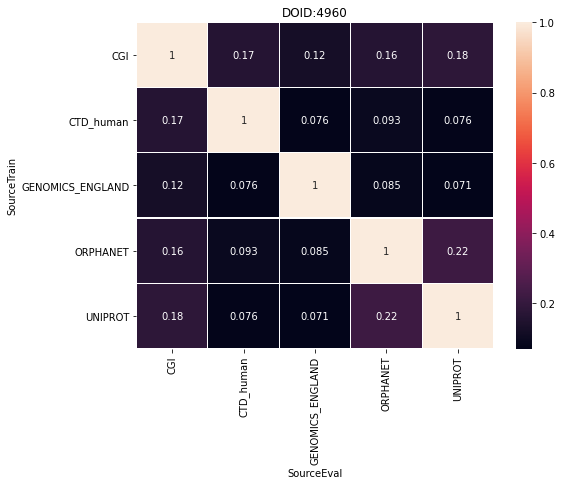

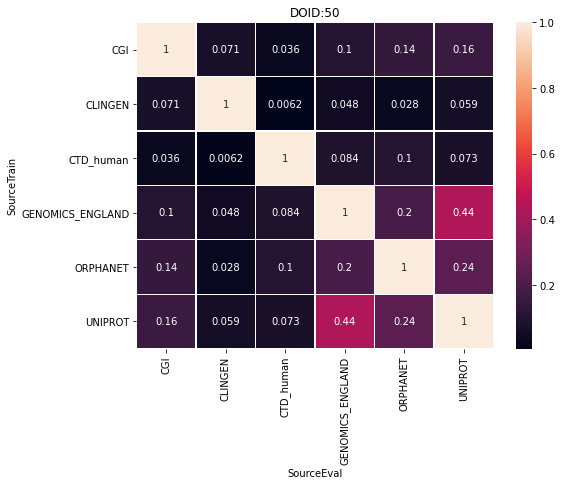

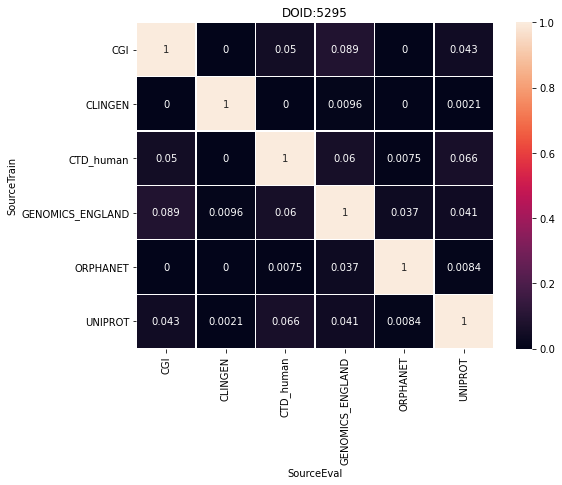

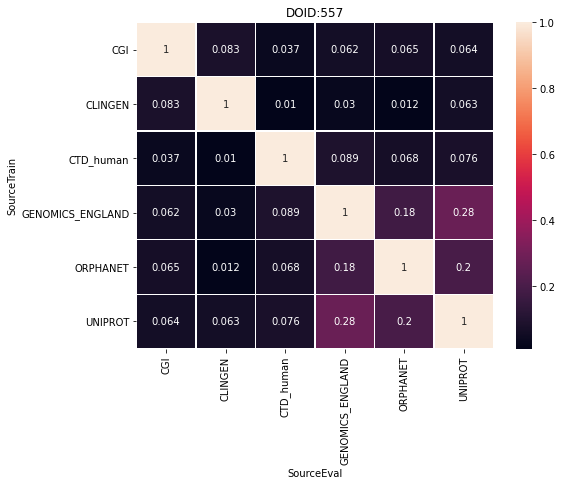

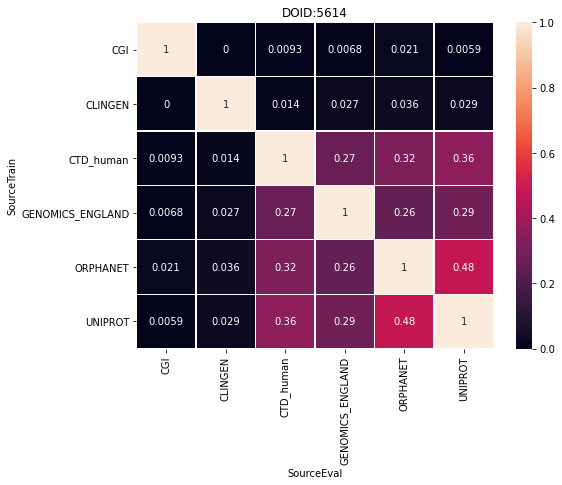

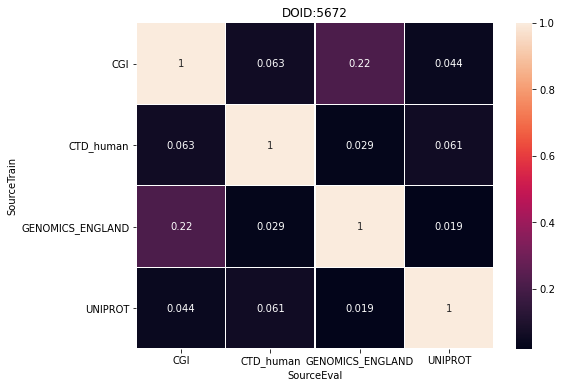

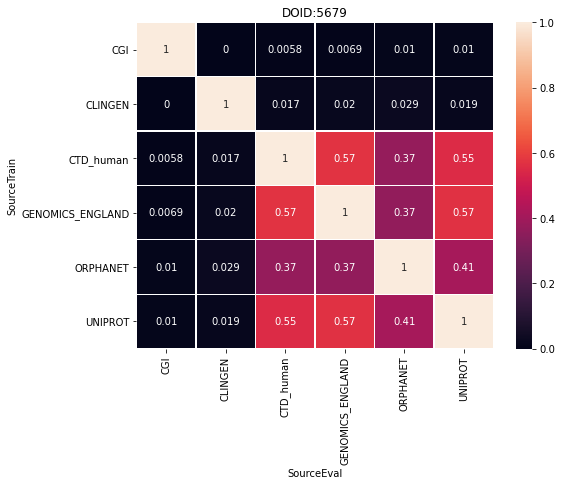

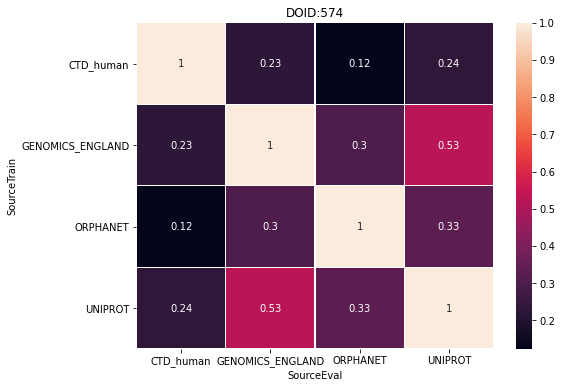

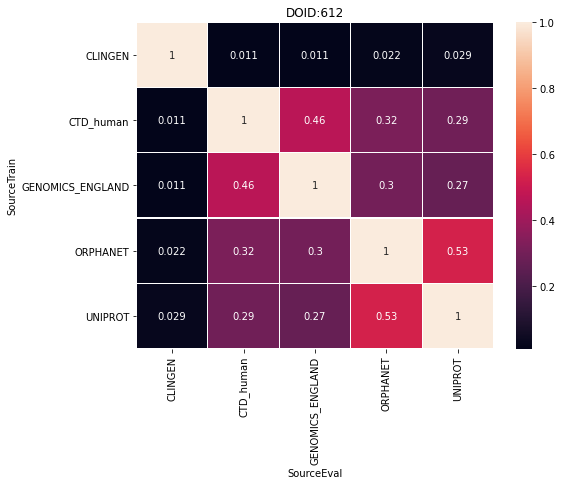

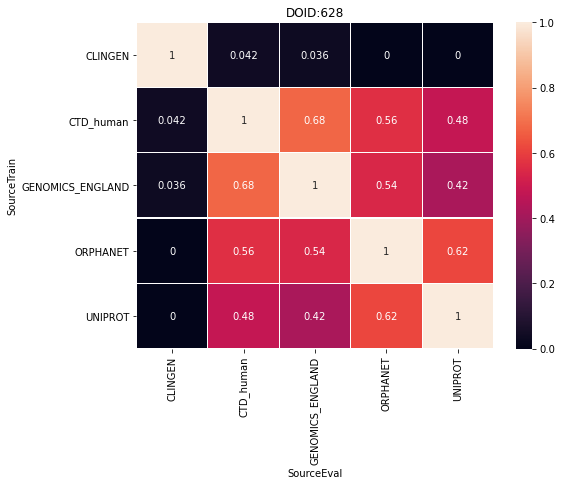

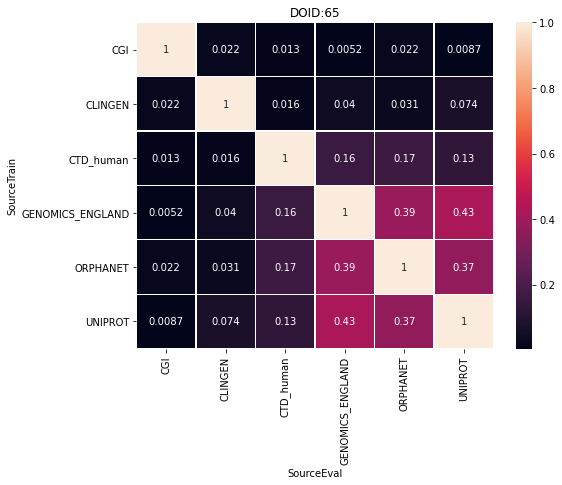

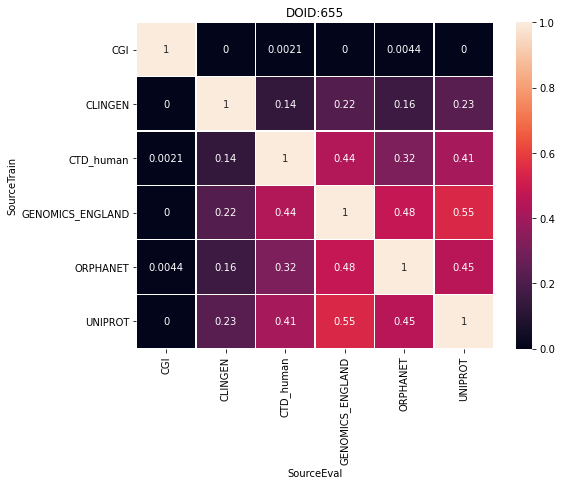

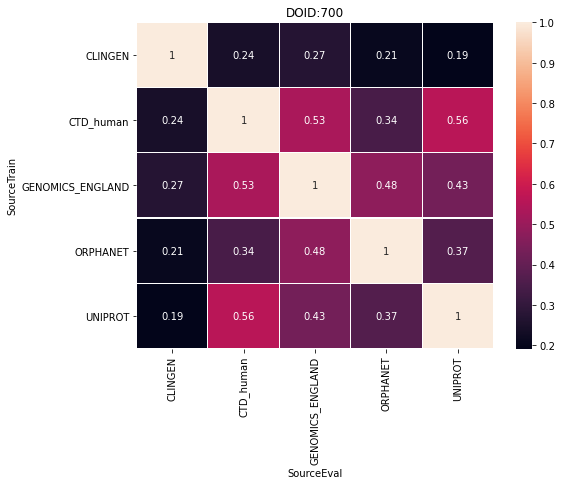

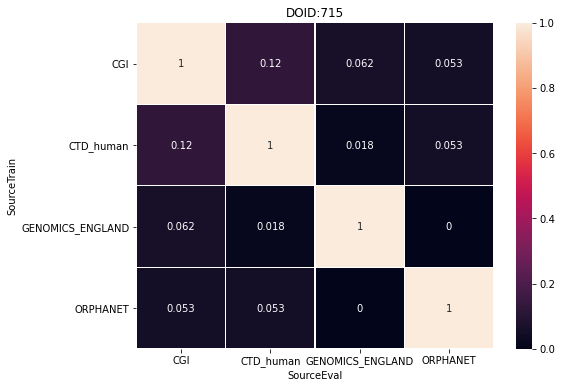

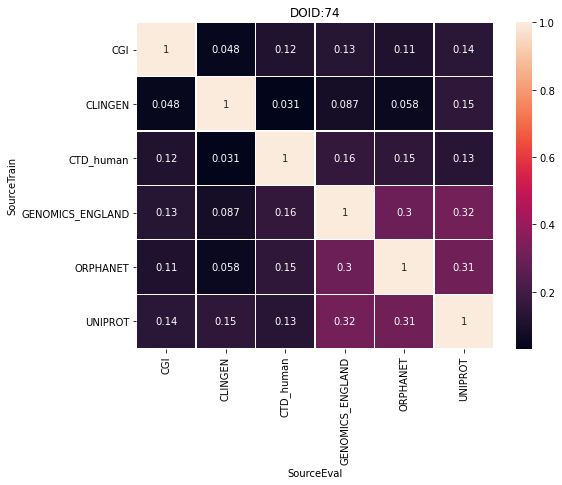

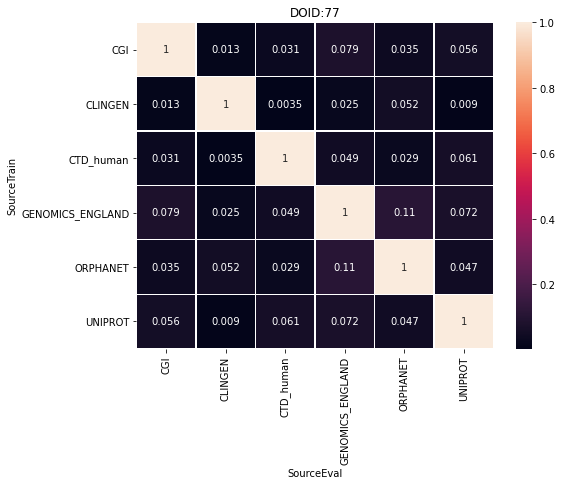

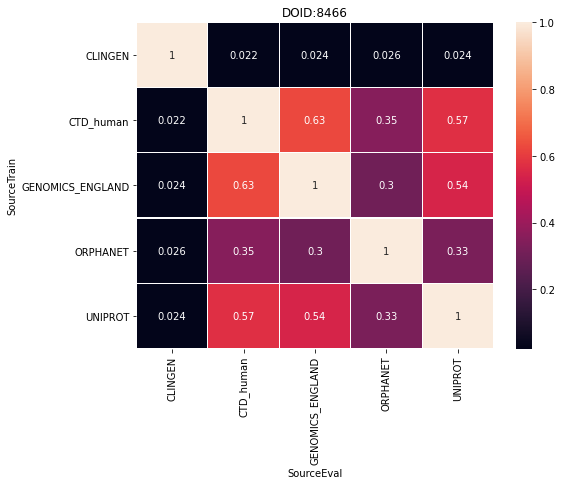

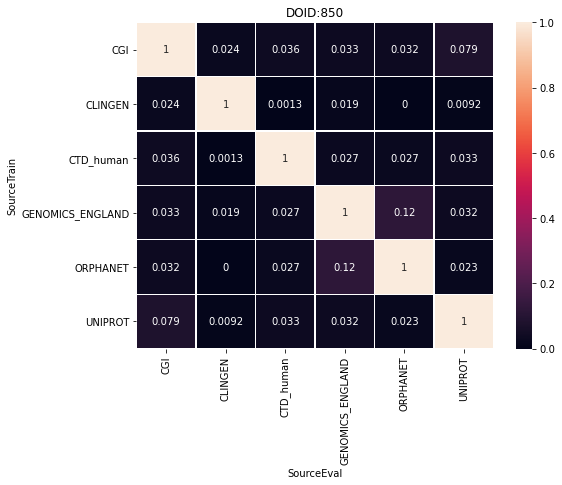

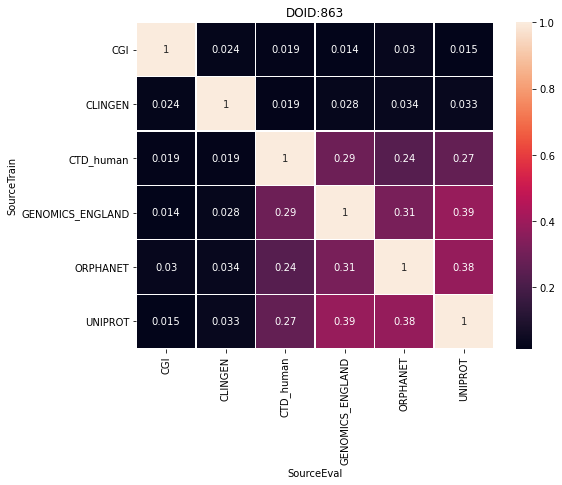

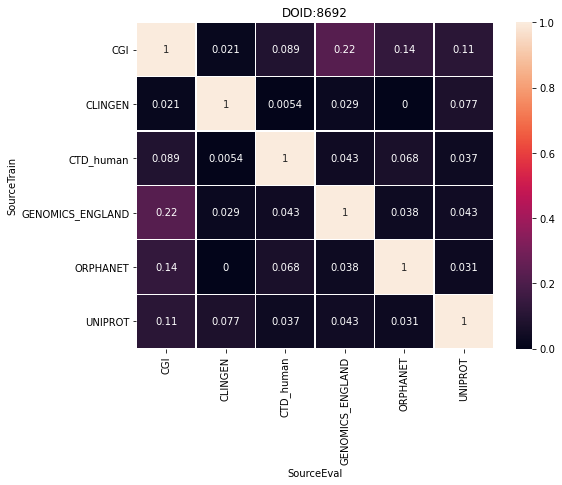

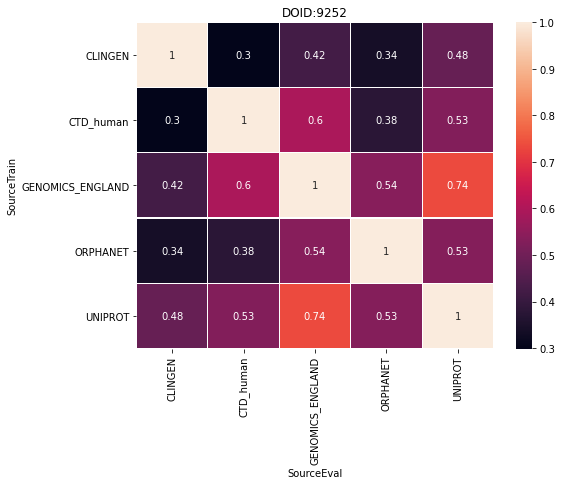

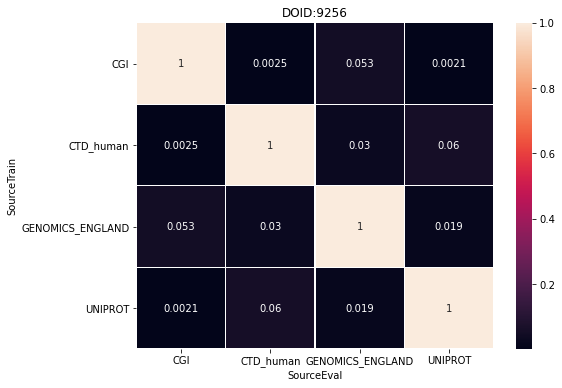

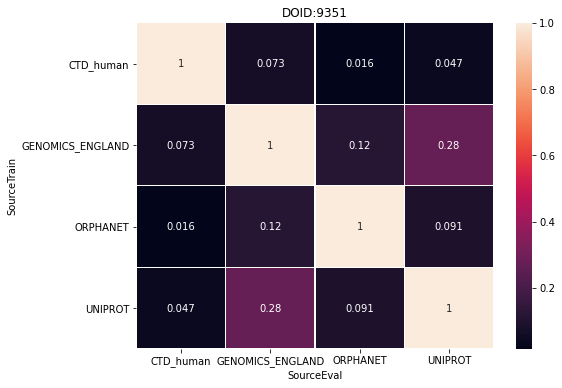

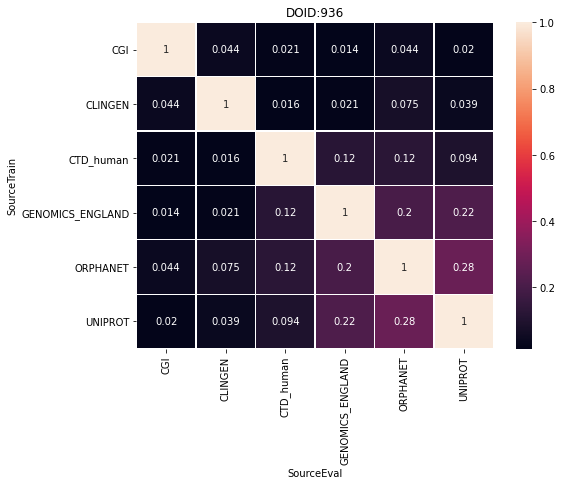

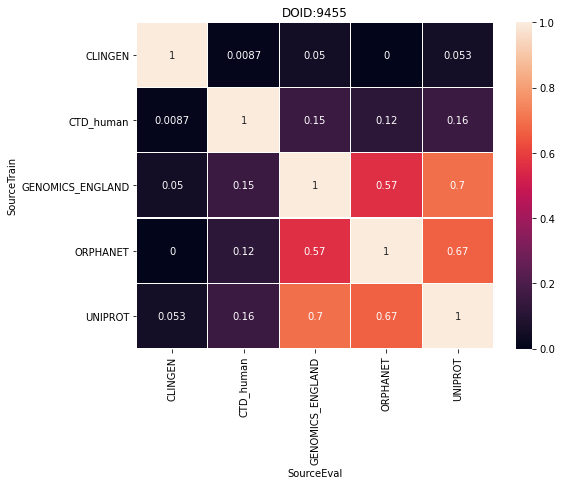

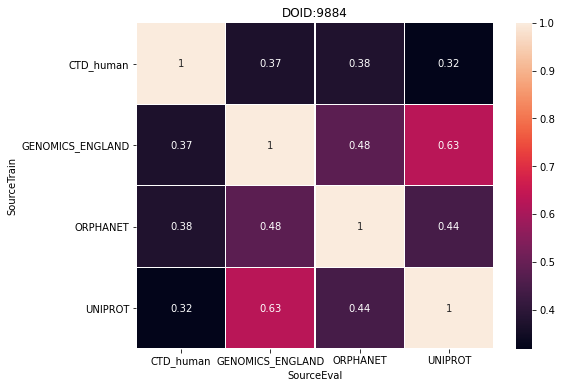

In [39]:
dict_of_DOIDS = dict(iter(resultGE.groupby('DOID')))

for DOID in dict_of_DOIDS:
    resulttrial = dict_of_DOIDS[DOID].pivot("SourceTrain", "SourceEval", "jaccardIndex")
    fig, ax = plt.subplots(figsize=(8,6))   
    ax = sns.heatmap(resulttrial, annot = True, linewidths = .25)
    plt.title(DOID)

In [38]:
#Function to run when you get the whole dataset:
import glob

path = "./eval"
all_files = glob.glob(path + "/*.tsv")
df = pd.concat((pd.read_csv(f, sep = '\t').assign(filename = f) for f in all_files))

df['filename'] = df['filename'].apply(lambda x: (x[7:]))
df[['DOID','SourceTrain']] = df.filename.str.split("_source=",expand=True)
df[['SourceTrain', 'Dummy', 'SourceEval']] = df.SourceTrain.str.split('=', expand = True)
df['SourceTrain'] = df['SourceTrain'].apply(lambda x: (x[:-6]))
df['SourceEval'] = df['SourceEval'].apply(lambda x: (x[:-4]))
df = df.drop(columns = ['filename', 'Dummy'])
df

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,CGI
0,0.708895,0.977403,1.990186,1.797541,1.191820,0.067797,0.118644,0.194915,DOID:936,CGI,UNIPROT
0,0.751768,1.353335,1.634851,1.634851,1.705241,0.055556,0.111111,0.291667,DOID:150,CTD-human,UNIPROT
0,0.645484,0.817277,1.232059,1.232059,1.232059,0.039216,0.078431,0.196078,DOID:263,UNIPROT,ORPHANET
0,0.813164,2.210550,3.086537,2.786976,2.349571,0.145455,0.236364,0.436364,DOID:2256,GENOMICS-ENGLAND,ORPHANET
...,...,...,...,...,...,...,...,...,...,...,...
0,0.773690,0.517985,0.348399,0.541044,0.645380,0.011532,0.026359,0.070840,DOID:74,GENOMICS-ENGLAND,CTD-human
0,0.672131,0.669673,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:1793,GENOMICS-ENGLAND,UNIPROT
0,0.796087,1.007461,1.588456,1.353990,1.266528,0.036364,0.061818,0.145455,DOID:0080199,CTD-human,CTD-human
0,0.834118,0.460756,0.612854,0.612854,0.612854,0.011050,0.022099,0.055249,DOID:2914,CTD-human,CTD-human


In [41]:
resultGE

,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex
0,DOID:0014667,CLINGEN,CLINGEN,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{51204, 3081, 9997, 374291, 55572, 275, 55065,...",1.000000
1,DOID:0014667,CLINGEN,CGI,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...",{4615},0.000000
2,DOID:0014667,CLINGEN,CTD_human,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{2, 10243, 51204, 2053, 2055, 2056, 12, 18, 55...",0.069502
3,DOID:0014667,CLINGEN,GENOMICS_ENGLAND,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{644096, 3073, 3074, 10243, 7172, 3077, 378884...",0.173302
4,DOID:0014667,CLINGEN,UNIPROT,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{644096, 1537, 514, 140803, 90624, 3077, 10243...",0.201413
...,...,...,...,...,...,...
2156,DOID:9884,GENOMICS_ENGLAND,UNIPROT,"{7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...","{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...",0.627119
2157,DOID:9884,UNIPROT,ORPHANET,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...","{7169, 1282, 29954, 9987, 1674, 1291, 1292, 12...",0.444444
2158,DOID:9884,UNIPROT,CTD_human,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...","{7169, 29954, 7170, 1281, 1026, 1291, 1292, 12...",0.317647
2159,DOID:9884,UNIPROT,GENOMICS_ENGLAND,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...","{7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...",0.627119


In [43]:
resultGE.loc[resultGE['SourceTrain'] == 'GENOMICS_ENGLAND', 'SourceTrain'] = 'GENOMICS-ENGLAND'

In [45]:
resultGE.loc[resultGE['SourceEval'] == 'CTD_human', 'SourceEval'] = 'CTD-human'

In [58]:
resultGE.loc[resultGE['SourceTrain'] == 'CTD_human', 'SourceTrain'] = 'CTD-human'

In [59]:
resultGE.loc[resultGE['SourceEval'] == 'GENOMICS_ENGLAND', 'SourceEval'] = 'GENOMICS-ENGLAND'

In [61]:
finale = df.merge(resultGE, how = 'inner')
finale

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,CGI,"{4609, 2052, 54790, 3082, 359948, 171023, 3605...","{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",0.089202
1,0.708895,0.977403,1.990186,1.797541,1.191820,0.067797,0.118644,0.194915,DOID:936,CGI,UNIPROT,"{3845, 84231, 5395, 673, 546, 4771, 1956, 5156...","{3329, 1282, 2051, 1018, 378884, 57094, 55561,...",0.020408
2,0.751768,1.353335,1.634851,1.634851,1.705241,0.055556,0.111111,0.291667,DOID:150,CTD-human,UNIPROT,"{55297, 1, 10243, 4099, 2053, 151556, 79875, 2...","{7552, 10369, 8450, 23431, 6664, 55690, 1804, ...",0.062048
3,0.645484,0.817277,1.232059,1.232059,1.232059,0.039216,0.078431,0.196078,DOID:263,UNIPROT,ORPHANET,"{7428, 4233, 29072, 657, 53904, 2324, 2081, 67...","{2304, 283008, 3845, 7175, 51079, 51592, 4233,...",0.054795
4,0.813164,2.210550,3.086537,2.786976,2.349571,0.145455,0.236364,0.436364,DOID:2256,GENOMICS-ENGLAND,ORPHANET,"{1280, 23169, 64131, 6662, 6023, 4998, 5000, 8...","{1280, 23169, 64131, 6662, 8200, 649, 60681, 2...",0.476744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0.773690,0.517985,0.348399,0.541044,0.645380,0.011532,0.026359,0.070840,DOID:74,GENOMICS-ENGLAND,CTD-human,"{7171, 1029, 54790, 4615, 2056, 2057, 51206, 9...","{2052, 51206, 2056, 2057, 10, 8202, 6157, 1000...",0.162857
2089,0.672131,0.669673,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:1793,GENOMICS-ENGLAND,UNIPROT,"{285282, 7157}","{32, 225, 84448, 4185, 84260, 1029, 100, 26154...",0.000000
2090,0.796087,1.007461,1.588456,1.353990,1.266528,0.036364,0.061818,0.145455,DOID:0080199,CTD-human,CTD-human,"{10241, 51203, 100499467, 10257, 19, 2068, 21,...","{10241, 51203, 100499467, 10257, 19, 2068, 21,...",1.000000
2091,0.834118,0.460756,0.612854,0.612854,0.612854,0.011050,0.022099,0.055249,DOID:2914,CTD-human,CTD-human,"{2052, 2056, 10, 8202, 100048912, 55315, 10261...","{2052, 2056, 10, 8202, 100048912, 55315, 10261...",1.000000


In [57]:
finale['SourceEval'].unique()

array(['UNIPROT', 'ORPHANET', 'CLINGEN', 'CTD-human', 'CGI', 'PSYGENET'],
      dtype=object)

In [52]:
df

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,CGI
0,0.708895,0.977403,1.990186,1.797541,1.191820,0.067797,0.118644,0.194915,DOID:936,CGI,UNIPROT
0,0.751768,1.353335,1.634851,1.634851,1.705241,0.055556,0.111111,0.291667,DOID:150,CTD-human,UNIPROT
0,0.645484,0.817277,1.232059,1.232059,1.232059,0.039216,0.078431,0.196078,DOID:263,UNIPROT,ORPHANET
0,0.813164,2.210550,3.086537,2.786976,2.349571,0.145455,0.236364,0.436364,DOID:2256,GENOMICS-ENGLAND,ORPHANET
...,...,...,...,...,...,...,...,...,...,...,...
0,0.773690,0.517985,0.348399,0.541044,0.645380,0.011532,0.026359,0.070840,DOID:74,GENOMICS-ENGLAND,CTD-human
0,0.672131,0.669673,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:1793,GENOMICS-ENGLAND,UNIPROT
0,0.796087,1.007461,1.588456,1.353990,1.266528,0.036364,0.061818,0.145455,DOID:0080199,CTD-human,CTD-human
0,0.834118,0.460756,0.612854,0.612854,0.612854,0.011050,0.022099,0.055249,DOID:2914,CTD-human,CTD-human


In [55]:
finale['DOID'].unique()

array(['DOID:936', 'DOID:263', 'DOID:2256', 'DOID:3119', 'DOID:0050387',
       'DOID:1240', 'DOID:2531', 'DOID:1342', 'DOID:9351', 'DOID:178',
       'DOID:50', 'DOID:1781', 'DOID:3620', 'DOID:5295', 'DOID:3905',
       'DOID:850', 'DOID:10155', 'DOID:0060058', 'DOID:4451',
       'DOID:0080001', 'DOID:65', 'DOID:0050700', 'DOID:655', 'DOID:612',
       'DOID:409', 'DOID:3996', 'DOID:3070', 'DOID:1287', 'DOID:700',
       'DOID:114', 'DOID:2994', 'DOID:480', 'DOID:1324', 'DOID:628',
       'DOID:12449', 'DOID:557', 'DOID:162', 'DOID:2355', 'DOID:299',
       'DOID:1443', 'DOID:3146', 'DOID:0080199', 'DOID:863', 'DOID:2914',
       'DOID:305', 'DOID:0014667', 'DOID:9884', 'DOID:1749', 'DOID:8466',
       'DOID:9256', 'DOID:77', 'DOID:4467', 'DOID:37', 'DOID:74',
       'DOID:8692', 'DOID:403', 'DOID:1793', 'DOID:0050951', 'DOID:4960',
       'DOID:5614', 'DOID:3571', 'DOID:1289', 'DOID:715', 'DOID:1247',
       'DOID:5679', 'DOID:150', 'DOID:9455', 'DOID:0050534', 'DOID:423',
       'D

In [69]:
finaletest = finale.drop(columns = ['auROC', 'log2(auPRC/prior)', 'log2(P@r10/prior)', 'log2(P@r20/prior)',
       'log2(P@r50/prior)', 'R@r10', 'R@r20', 'R@r50', 'geneId1', 'geneId2', 'jaccardIndex', ])
finaletest

,DOID,SourceTrain,SourceEval
0,DOID:8692,CTD-human,CGI
1,DOID:936,CGI,UNIPROT
2,DOID:150,CTD-human,UNIPROT
3,DOID:263,UNIPROT,ORPHANET
4,DOID:2256,GENOMICS-ENGLAND,ORPHANET
...,...,...,...
2088,DOID:74,GENOMICS-ENGLAND,CTD-human
2089,DOID:1793,GENOMICS-ENGLAND,UNIPROT
2090,DOID:0080199,CTD-human,CTD-human
2091,DOID:2914,CTD-human,CTD-human


In [70]:
dftest = df.drop(columns = ['auROC', 'log2(auPRC/prior)', 'log2(P@r10/prior)', 'log2(P@r20/prior)',
       'log2(P@r50/prior)', 'R@r10', 'R@r20', 'R@r50'])
dftest

,DOID,SourceTrain,SourceEval
0,DOID:8692,CTD-human,CGI
0,DOID:936,CGI,UNIPROT
0,DOID:150,CTD-human,UNIPROT
0,DOID:263,UNIPROT,ORPHANET
0,DOID:2256,GENOMICS-ENGLAND,ORPHANET
...,...,...,...
0,DOID:74,GENOMICS-ENGLAND,CTD-human
0,DOID:1793,GENOMICS-ENGLAND,UNIPROT
0,DOID:0080199,CTD-human,CTD-human
0,DOID:2914,CTD-human,CTD-human


In [72]:
finale

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,CGI,"{4609, 2052, 54790, 3082, 359948, 171023, 3605...","{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",0.089202
1,0.708895,0.977403,1.990186,1.797541,1.191820,0.067797,0.118644,0.194915,DOID:936,CGI,UNIPROT,"{3845, 84231, 5395, 673, 546, 4771, 1956, 5156...","{3329, 1282, 2051, 1018, 378884, 57094, 55561,...",0.020408
2,0.751768,1.353335,1.634851,1.634851,1.705241,0.055556,0.111111,0.291667,DOID:150,CTD-human,UNIPROT,"{55297, 1, 10243, 4099, 2053, 151556, 79875, 2...","{7552, 10369, 8450, 23431, 6664, 55690, 1804, ...",0.062048
3,0.645484,0.817277,1.232059,1.232059,1.232059,0.039216,0.078431,0.196078,DOID:263,UNIPROT,ORPHANET,"{7428, 4233, 29072, 657, 53904, 2324, 2081, 67...","{2304, 283008, 3845, 7175, 51079, 51592, 4233,...",0.054795
4,0.813164,2.210550,3.086537,2.786976,2.349571,0.145455,0.236364,0.436364,DOID:2256,GENOMICS-ENGLAND,ORPHANET,"{1280, 23169, 64131, 6662, 6023, 4998, 5000, 8...","{1280, 23169, 64131, 6662, 8200, 649, 60681, 2...",0.476744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0.773690,0.517985,0.348399,0.541044,0.645380,0.011532,0.026359,0.070840,DOID:74,GENOMICS-ENGLAND,CTD-human,"{7171, 1029, 54790, 4615, 2056, 2057, 51206, 9...","{2052, 51206, 2056, 2057, 10, 8202, 6157, 1000...",0.162857
2089,0.672131,0.669673,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:1793,GENOMICS-ENGLAND,UNIPROT,"{285282, 7157}","{32, 225, 84448, 4185, 84260, 1029, 100, 26154...",0.000000
2090,0.796087,1.007461,1.588456,1.353990,1.266528,0.036364,0.061818,0.145455,DOID:0080199,CTD-human,CTD-human,"{10241, 51203, 100499467, 10257, 19, 2068, 21,...","{10241, 51203, 100499467, 10257, 19, 2068, 21,...",1.000000
2091,0.834118,0.460756,0.612854,0.612854,0.612854,0.011050,0.022099,0.055249,DOID:2914,CTD-human,CTD-human,"{2052, 2056, 10, 8202, 100048912, 55315, 10261...","{2052, 2056, 10, 8202, 100048912, 55315, 10261...",1.000000


In [74]:
finaletest.value_counts()

DOID          SourceTrain  SourceEval      
DOID:0014667  CGI          CLINGEN             1
DOID:50       CTD-human    GENOMICS-ENGLAND    1
                           CLINGEN             1
                           CGI                 1
              CLINGEN      UNIPROT             1
                                              ..
DOID:2394     CGI          CGI                 1
DOID:2355     UNIPROT      UNIPROT             1
                           ORPHANET            1
                           GENOMICS-ENGLAND    1
DOID:9884     UNIPROT      UNIPROT             1
Length: 2093, dtype: int64

In [79]:
len(finale['DOID'].unique())

77

In [80]:
finale2 = df.merge(resultGE, indicator=True, how='outer')
finale2

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex,_merge
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,CGI,"{4609, 2052, 54790, 3082, 359948, 171023, 3605...","{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",0.089202,both
1,0.708895,0.977403,1.990186,1.797541,1.191820,0.067797,0.118644,0.194915,DOID:936,CGI,UNIPROT,"{3845, 84231, 5395, 673, 546, 4771, 1956, 5156...","{3329, 1282, 2051, 1018, 378884, 57094, 55561,...",0.020408,both
2,0.751768,1.353335,1.634851,1.634851,1.705241,0.055556,0.111111,0.291667,DOID:150,CTD-human,UNIPROT,"{55297, 1, 10243, 4099, 2053, 151556, 79875, 2...","{7552, 10369, 8450, 23431, 6664, 55690, 1804, ...",0.062048,both
3,0.645484,0.817277,1.232059,1.232059,1.232059,0.039216,0.078431,0.196078,DOID:263,UNIPROT,ORPHANET,"{7428, 4233, 29072, 657, 53904, 2324, 2081, 67...","{2304, 283008, 3845, 7175, 51079, 51592, 4233,...",0.054795,both
4,0.813164,2.210550,3.086537,2.786976,2.349571,0.145455,0.236364,0.436364,DOID:2256,GENOMICS-ENGLAND,ORPHANET,"{1280, 23169, 64131, 6662, 6023, 4998, 5000, 8...","{1280, 23169, 64131, 6662, 8200, 649, 60681, 2...",0.476744,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOID:8692,CGI,CLINGEN,"{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",{1050},0.021277,right_only
2162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOID:8692,CTD-human,CLINGEN,"{4609, 2052, 54790, 3082, 359948, 171023, 3605...",{1050},0.005405,right_only
2163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOID:8692,GENOMICS-ENGLAND,CLINGEN,"{2176, 641, 2177, 2178, 5888, 5889, 23305, 218...",{1050},0.028571,right_only
2164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOID:8692,UNIPROT,CLINGEN,"{2146, 339970, 3717, 54790, 7403, 29072, 2322,...",{1050},0.076923,right_only


In [83]:
finale2.tail(100)

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex,_merge
2066,0.770492,1.543523,2.007708,1.007708,-0.314220,0.071429,0.071429,0.071429,DOID:1793,CTD-human,UNIPROT,"{384, 3714, 1029, 3845, 23493, 6794, 3280, 406...","{32, 225, 84448, 4185, 84260, 1029, 100, 26154...",0.023810,both
2067,0.685140,1.042327,1.623174,1.430529,1.471171,0.051948,0.090909,0.233766,DOID:557,CGI,ORPHANET,"{7490, 7428, 6598, 4233, 201163, 6927, 7248, 7...","{2304, 3845, 7175, 6927, 11281, 129563, 4893, ...",0.064516,both
2068,0.795349,2.702506,3.662157,3.340229,2.603263,0.212766,0.340426,0.510638,DOID:8692,ORPHANET,CGI,"{5573, 4869, 81608, 2120, 359948, 2322, 7704, ...","{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",0.135593,both
2069,0.824086,2.319956,2.347568,2.932530,2.440677,0.103448,0.310345,0.551724,DOID:65,CLINGEN,CLINGEN,"{6016, 1281, 3845, 5894, 3081, 22800, 5781, 13...","{6016, 1281, 3845, 5894, 3081, 22800, 5781, 13...",1.000000,both
2070,0.700183,0.826543,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:0050534,ORPHANET,GENOMICS-ENGLAND,"{6011, 6295}","{9187, 2916, 60506, 5158, 345193, 778, 440435,...",0.083333,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOID:8692,CGI,CLINGEN,"{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",{1050},0.021277,right_only
2162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOID:8692,CTD-human,CLINGEN,"{4609, 2052, 54790, 3082, 359948, 171023, 3605...",{1050},0.005405,right_only
2163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOID:8692,GENOMICS-ENGLAND,CLINGEN,"{2176, 641, 2177, 2178, 5888, 5889, 23305, 218...",{1050},0.028571,right_only
2164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOID:8692,UNIPROT,CLINGEN,"{2146, 339970, 3717, 54790, 7403, 29072, 2322,...",{1050},0.076923,right_only


In [84]:
df.loc[df['DOID']=='DOID:8692']

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,CGI
0,0.718978,1.806436,2.505891,2.090853,1.991318,0.100000,0.150000,0.350000,DOID:8692,UNIPROT,ORPHANET
0,0.752640,2.188159,3.147584,2.925191,2.105764,0.148936,0.255319,0.361702,DOID:8692,GENOMICS-ENGLAND,CGI
0,0.846142,2.938505,3.321103,3.195573,2.662140,0.171429,0.314286,0.542857,DOID:8692,CGI,GENOMICS-ENGLAND
0,0.845673,3.228809,3.736141,3.643032,2.806530,0.228571,0.428571,0.600000,DOID:8692,GENOMICS-ENGLAND,GENOMICS-ENGLAND
0,0.488217,0.126967,0.736141,0.736141,-0.585787,0.028571,0.057143,0.057143,DOID:8692,UNIPROT,GENOMICS-ENGLAND
0,0.500000,0.000000,-inf,-inf,-0.212439,0.000000,0.000000,0.076923,DOID:8692,CLINGEN,UNIPROT
0,0.500000,0.000000,0.340229,0.340229,0.825656,0.021277,0.042553,0.148936,DOID:8692,CLINGEN,CGI
0,0.500000,0.000000,1.736141,1.736141,1.414213,0.057143,0.114286,0.228571,DOID:8692,CLINGEN,GENOMICS-ENGLAND
0,0.821816,1.235118,1.676100,1.582990,1.563625,0.043716,0.081967,0.202186,DOID:8692,CGI,CTD-human


In [85]:
finale2.loc[finale2['DOID']=='DOID:8692']

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex,_merge
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,CGI,"{4609, 2052, 54790, 3082, 359948, 171023, 3605...","{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",0.089202,both
141,0.718978,1.806436,2.505891,2.090853,1.991318,0.100000,0.150000,0.350000,DOID:8692,UNIPROT,ORPHANET,"{2146, 339970, 3717, 54790, 7403, 29072, 2322,...","{5573, 4869, 81608, 2120, 359948, 2322, 7704, ...",0.031250,both
269,0.752640,2.188159,3.147584,2.925191,2.105764,0.148936,0.255319,0.361702,DOID:8692,GENOMICS-ENGLAND,CGI,"{2176, 641, 2177, 2178, 5888, 5889, 23305, 218...","{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",0.223881,both
294,0.846142,2.938505,3.321103,3.195573,2.662140,0.171429,0.314286,0.542857,DOID:8692,CGI,GENOMICS-ENGLAND,"{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...","{2176, 641, 2177, 2178, 5888, 5889, 23305, 218...",0.223881,both
323,0.845673,3.228809,3.736141,3.643032,2.806530,0.228571,0.428571,0.600000,DOID:8692,GENOMICS-ENGLAND,GENOMICS-ENGLAND,"{2176, 641, 2177, 2178, 5888, 5889, 23305, 218...","{2176, 641, 2177, 2178, 5888, 5889, 23305, 218...",1.000000,both
383,0.488217,0.126967,0.736141,0.736141,-0.585787,0.028571,0.057143,0.057143,DOID:8692,UNIPROT,GENOMICS-ENGLAND,"{2146, 339970, 3717, 54790, 7403, 29072, 2322,...","{2176, 641, 2177, 2178, 5888, 5889, 23305, 218...",0.043478,both
435,0.500000,0.000000,-inf,-inf,-0.212439,0.000000,0.000000,0.076923,DOID:8692,CLINGEN,UNIPROT,{1050},"{2146, 339970, 3717, 54790, 7403, 29072, 2322,...",0.076923,both
475,0.500000,0.000000,0.340229,0.340229,0.825656,0.021277,0.042553,0.148936,DOID:8692,CLINGEN,CGI,{1050},"{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",0.021277,both
596,0.500000,0.000000,1.736141,1.736141,1.414213,0.057143,0.114286,0.228571,DOID:8692,CLINGEN,GENOMICS-ENGLAND,{1050},"{2176, 641, 2177, 2178, 5888, 5889, 23305, 218...",0.028571,both
663,0.821816,1.235118,1.676100,1.582990,1.563625,0.043716,0.081967,0.202186,DOID:8692,CGI,CTD-human,"{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...","{4609, 2052, 54790, 3082, 359948, 171023, 3605...",0.089202,both


In [87]:
finale2test = finale2[finale2['_merge'].map(lambda d: d) == 'left_only']
finale2test

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex,_merge
774,0.584249,1.262507,-inf,-inf,-inf,0.0,0.0,0.0,DOID:2994,CTD-human,CLINGEN,NaN,NaN,NaN,left_only
1082,0.569597,1.212754,-inf,-inf,-inf,0.0,0.0,0.0,DOID:2994,GENOMICS-ENGLAND,CLINGEN,NaN,NaN,NaN,left_only
1344,0.664835,1.571835,-inf,-inf,-inf,0.0,0.0,0.0,DOID:2994,CGI,CLINGEN,NaN,NaN,NaN,left_only
1554,0.492674,0.976456,-inf,-inf,-inf,0.0,0.0,0.0,DOID:2994,ORPHANET,CLINGEN,NaN,NaN,NaN,left_only
1863,0.750916,1.997365,-inf,-inf,-inf,0.0,0.0,0.0,DOID:2994,UNIPROT,CLINGEN,NaN,NaN,NaN,left_only


In [88]:
result

,DOID,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10,geneSet,source,diseaseName
0,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{11200, 5889, 5892, 580, 4292, 6598, 7046, 436...",CLINGEN,cancer
1,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{2, 9, 10, 100499467, 8202, 12, 8204, 10004891...",CTD_human,cancer
2,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{2048, 1026, 1027, 7172, 1029, 1030, 1031, 171...",CGI,cancer
3,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{1027, 1028, 1029, 54790, 4615, 171023, 5649, ...",GENOMICS_ENGLAND,cancer
4,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6,"{2048, 4609, 7170, 7171, 1029, 54790, 4615, 71...",ORPHANET,cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,DOID:0110274,autosomal recessive limb-girdle muscular dystr...,0,0,12,23,9,0,20,8,30,3,"{729920, 29954, 1605, 55624, 60684, 11149, 203...",UNIPROT,autosomal recessive limb-girdle muscular dystr...
399,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14,3,"{778, 4308, 6295, 60506, 2779, 2784, 9187, 291...",CTD_human,congenital stationary night blindness
400,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14,3,"{9187, 2916, 60506, 5158, 345193, 778, 440435,...",GENOMICS_ENGLAND,congenital stationary night blindness
401,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14,3,"{6011, 6295}",ORPHANET,congenital stationary night blindness


In [89]:
resultGE

,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex
0,DOID:0014667,CLINGEN,CLINGEN,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{51204, 3081, 9997, 374291, 55572, 275, 55065,...",1.000000
1,DOID:0014667,CLINGEN,CGI,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...",{4615},0.000000
2,DOID:0014667,CLINGEN,CTD-human,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{2, 10243, 51204, 2053, 2055, 2056, 12, 18, 55...",0.069502
3,DOID:0014667,CLINGEN,GENOMICS-ENGLAND,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{644096, 3073, 3074, 10243, 7172, 3077, 378884...",0.173302
4,DOID:0014667,CLINGEN,UNIPROT,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...","{644096, 1537, 514, 140803, 90624, 3077, 10243...",0.201413
...,...,...,...,...,...,...
2156,DOID:9884,GENOMICS-ENGLAND,UNIPROT,"{7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...","{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...",0.627119
2157,DOID:9884,UNIPROT,ORPHANET,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...","{7169, 1282, 29954, 9987, 1674, 1291, 1292, 12...",0.444444
2158,DOID:9884,UNIPROT,CTD-human,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...","{7169, 29954, 7170, 1281, 1026, 1291, 1292, 12...",0.317647
2159,DOID:9884,UNIPROT,GENOMICS-ENGLAND,"{29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...","{7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...",0.627119


In [90]:
df.loc[df['DOID']=='DOID:2994']

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval
0,0.537837,0.068539,0.921997,0.506960,-0.078003,0.020050,0.030075,0.050125,DOID:2994,UNIPROT,CTD-human
0,0.644878,0.970566,0.987509,0.987509,0.987509,0.034483,0.068966,0.172414,DOID:2994,ORPHANET,ORPHANET
0,0.668769,0.712313,2.124515,1.414021,0.880589,0.063380,0.077465,0.133803,DOID:2994,ORPHANET,UNIPROT
0,0.857673,3.071926,3.619969,3.526860,2.821603,0.210526,0.394737,0.605263,DOID:2994,CGI,CGI
0,0.918643,3.280833,3.789894,3.619969,2.821603,0.236842,0.421053,0.605263,DOID:2994,CTD-human,CGI
0,0.713654,1.890098,2.987509,2.309437,2.250543,0.137931,0.172414,0.413793,DOID:2994,CGI,ORPHANET
0,0.766768,1.825099,1.987509,1.987509,1.835506,0.068966,0.137931,0.310345,DOID:2994,CTD-human,ORPHANET
0,0.760073,2.199119,3.201634,2.201634,1.879706,0.166667,0.166667,0.333333,DOID:2994,ORPHANET,GENOMICS-ENGLAND
0,0.584249,1.262507,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:2994,CTD-human,CLINGEN
0,0.740933,1.028109,1.761944,1.761944,1.333101,0.049296,0.098592,0.183099,DOID:2994,CTD-human,UNIPROT


In [91]:
result.loc[result['DOID']=='DOID:2994']

,DOID,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10,geneSet,source,diseaseName
115,DOID:2994,germ cell cancer,0,22,645,4,19,0,7,15,655,3,"{2052, 9, 10, 8202, 12, 2064, 2065, 10257, 553...",CTD_human,germ cell cancer
116,DOID:2994,germ cell cancer,0,22,645,4,19,0,7,15,655,3,"{2048, 4609, 11200, 6790, 6794, 207, 8915, 840...",CGI,germ cell cancer
117,DOID:2994,germ cell cancer,0,22,645,4,19,0,7,15,655,3,"{60528, 4481, 6041, 3815}",GENOMICS_ENGLAND,germ cell cancer
118,DOID:2994,germ cell cancer,0,22,645,4,19,0,7,15,655,3,"{2048, 4481, 11200, 4683, 6928, 79703, 6041, 1...",ORPHANET,germ cell cancer
119,DOID:2994,germ cell cancer,0,22,645,4,19,0,7,15,655,3,"{199713, 3973, 3815, 10664, 6793, 6794, 2261}",UNIPROT,germ cell cancer


In [92]:
resultGE.loc[resultGE['DOID']=='DOID:2994']

,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex
891,DOID:2994,CGI,CGI,"{2048, 4609, 11200, 6790, 6794, 207, 8915, 840...","{2048, 4609, 11200, 6790, 6794, 207, 8915, 840...",1.000000
892,DOID:2994,CGI,CTD-human,"{2048, 4609, 11200, 6790, 6794, 207, 8915, 840...","{2052, 9, 10, 8202, 12, 2064, 2065, 10257, 553...",0.027735
893,DOID:2994,CGI,GENOMICS-ENGLAND,"{2048, 4609, 11200, 6790, 6794, 207, 8915, 840...","{60528, 4481, 6041, 3815}",0.000000
894,DOID:2994,CGI,UNIPROT,"{2048, 4609, 11200, 6790, 6794, 207, 8915, 840...","{199713, 3973, 3815, 10664, 6793, 6794, 2261}",0.035714
895,DOID:2994,CGI,ORPHANET,"{2048, 4609, 11200, 6790, 6794, 207, 8915, 840...","{2048, 4481, 11200, 4683, 6928, 79703, 6041, 1...",0.108108
896,DOID:2994,CTD-human,CGI,"{2052, 9, 10, 8202, 12, 2064, 2065, 10257, 553...","{2048, 4609, 11200, 6790, 6794, 207, 8915, 840...",0.027735
897,DOID:2994,CTD-human,CTD-human,"{2052, 9, 10, 8202, 12, 2064, 2065, 10257, 553...","{2052, 9, 10, 8202, 12, 2064, 2065, 10257, 553...",1.000000
898,DOID:2994,CTD-human,GENOMICS-ENGLAND,"{2052, 9, 10, 8202, 12, 2064, 2065, 10257, 553...","{60528, 4481, 6041, 3815}",0.006202
899,DOID:2994,CTD-human,UNIPROT,"{2052, 9, 10, 8202, 12, 2064, 2065, 10257, 553...","{199713, 3973, 3815, 10664, 6793, 6794, 2261}",0.007728
900,DOID:2994,CTD-human,ORPHANET,"{2052, 9, 10, 8202, 12, 2064, 2065, 10257, 553...","{2048, 4481, 11200, 4683, 6928, 79703, 6041, 1...",0.021538


In [93]:
propagated.loc[propagated['DOID']=='DOID:2994']

,DOID,geneSet,source,diseaseName
3052,DOID:2994,"{2052, 9, 10, 8202, 12, 2064, 2065, 10257, 553...",CTD_human,germ cell cancer
156,DOID:2994,"{2048, 4609, 11200, 6790, 6794, 207, 8915, 840...",CGI,germ cell cancer
3193,DOID:2994,"{60528, 4481, 6041, 3815}",GENOMICS_ENGLAND,germ cell cancer
1916,DOID:2994,"{2048, 4481, 11200, 4683, 6928, 79703, 6041, 1...",ORPHANET,germ cell cancer
2687,DOID:2994,"{199713, 3973, 3815, 10664, 6793, 6794, 2261}",UNIPROT,germ cell cancer


In [95]:
trial = pd.read_csv('DesiredDataArjunAllDisease.tsv', sep = "\t")
trial

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
0,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574
1,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206
2,DOID:150,disease of mental health,21,0,955,433,92,1132,72,12,2069
3,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987
4,DOID:3119,gastrointestinal system cancer,3,76,993,29,17,0,528,6,1463
...,...,...,...,...,...,...,...,...,...,...,...
4817,DOID:0111367,error,0,0,1,1,1,0,1,1,1
4818,DOID:0111370,error,0,0,1,0,0,0,1,1,1
4819,DOID:0111371,error,0,0,1,0,1,0,1,1,1
4820,DOID:0111372,error,0,0,1,1,1,0,1,1,1


In [97]:
trial.loc[trial['dis_doid']=='DOID:2994']

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
27,DOID:2994,germ cell cancer,0,22,645,4,19,0,7,15,655


In [98]:
finale

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,SourceEval,geneId1,geneId2,jaccardIndex
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,CGI,"{4609, 2052, 54790, 3082, 359948, 171023, 3605...","{2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...",0.089202
1,0.708895,0.977403,1.990186,1.797541,1.191820,0.067797,0.118644,0.194915,DOID:936,CGI,UNIPROT,"{3845, 84231, 5395, 673, 546, 4771, 1956, 5156...","{3329, 1282, 2051, 1018, 378884, 57094, 55561,...",0.020408
2,0.751768,1.353335,1.634851,1.634851,1.705241,0.055556,0.111111,0.291667,DOID:150,CTD-human,UNIPROT,"{55297, 1, 10243, 4099, 2053, 151556, 79875, 2...","{7552, 10369, 8450, 23431, 6664, 55690, 1804, ...",0.062048
3,0.645484,0.817277,1.232059,1.232059,1.232059,0.039216,0.078431,0.196078,DOID:263,UNIPROT,ORPHANET,"{7428, 4233, 29072, 657, 53904, 2324, 2081, 67...","{2304, 283008, 3845, 7175, 51079, 51592, 4233,...",0.054795
4,0.813164,2.210550,3.086537,2.786976,2.349571,0.145455,0.236364,0.436364,DOID:2256,GENOMICS-ENGLAND,ORPHANET,"{1280, 23169, 64131, 6662, 6023, 4998, 5000, 8...","{1280, 23169, 64131, 6662, 8200, 649, 60681, 2...",0.476744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0.773690,0.517985,0.348399,0.541044,0.645380,0.011532,0.026359,0.070840,DOID:74,GENOMICS-ENGLAND,CTD-human,"{7171, 1029, 54790, 4615, 2056, 2057, 51206, 9...","{2052, 51206, 2056, 2057, 10, 8202, 6157, 1000...",0.162857
2089,0.672131,0.669673,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:1793,GENOMICS-ENGLAND,UNIPROT,"{285282, 7157}","{32, 225, 84448, 4185, 84260, 1029, 100, 26154...",0.000000
2090,0.796087,1.007461,1.588456,1.353990,1.266528,0.036364,0.061818,0.145455,DOID:0080199,CTD-human,CTD-human,"{10241, 51203, 100499467, 10257, 19, 2068, 21,...","{10241, 51203, 100499467, 10257, 19, 2068, 21,...",1.000000
2091,0.834118,0.460756,0.612854,0.612854,0.612854,0.011050,0.022099,0.055249,DOID:2914,CTD-human,CTD-human,"{2052, 2056, 10, 8202, 100048912, 55315, 10261...","{2052, 2056, 10, 8202, 100048912, 55315, 10261...",1.000000


In [99]:
selected

,DOID,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10
0,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6
1,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206,6
2,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987,5
3,DOID:3119,gastrointestinal system cancer,3,76,993,29,17,0,528,6,1463,5
4,DOID:305,carcinoma,2,112,1087,36,36,0,211,166,1310,5
...,...,...,...,...,...,...,...,...,...,...,...,...
72,DOID:1342,congenital hypoplastic anemia,9,0,25,54,20,0,14,32,60,4
73,DOID:1793,pancreatic cancer,0,17,28,2,8,0,15,107,58,3
74,DOID:628,combined T cell and B cell immunodeficiency,1,0,24,28,26,0,16,42,38,4
75,DOID:0110274,autosomal recessive limb-girdle muscular dystr...,0,0,12,23,9,0,20,8,30,3


In [100]:
finale = finale.merge(selected)
finale

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,...,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,...,1,47,185,35,20,0,13,26,240,5
1,0.718978,1.806436,2.505891,2.090853,1.991318,0.100000,0.150000,0.350000,DOID:8692,UNIPROT,...,1,47,185,35,20,0,13,26,240,5
2,0.752640,2.188159,3.147584,2.925191,2.105764,0.148936,0.255319,0.361702,DOID:8692,GENOMICS-ENGLAND,...,1,47,185,35,20,0,13,26,240,5
3,0.846142,2.938505,3.321103,3.195573,2.662140,0.171429,0.314286,0.542857,DOID:8692,CGI,...,1,47,185,35,20,0,13,26,240,5
4,0.845673,3.228809,3.736141,3.643032,2.806530,0.228571,0.428571,0.600000,DOID:8692,GENOMICS-ENGLAND,...,1,47,185,35,20,0,13,26,240,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0.596632,0.821606,1.830357,0.830357,1.093391,0.062500,0.062500,0.187500,DOID:365,UNIPROT,...,0,16,148,0,0,0,10,5,163,3
2089,0.546655,0.155536,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:365,UNIPROT,...,0,16,148,0,0,0,10,5,163,3
2090,0.797173,1.476324,1.736966,2.017074,2.000000,0.047619,0.115646,0.285714,DOID:365,CTD-human,...,0,16,148,0,0,0,10,5,163,3
2091,0.833635,3.221300,3.493135,3.815063,2.756169,0.200000,0.500000,0.600000,DOID:365,CTD-human,...,0,16,148,0,0,0,10,5,163,3


In [103]:
finale.columns

Index(['auROC', 'log2(auPRC/prior)', 'log2(P@r10/prior)', 'log2(P@r20/prior)',
       'log2(P@r50/prior)', 'R@r10', 'R@r20', 'R@r50', 'DOID', 'SourceTrain',
       'SourceEval', 'geneId1', 'geneId2', 'jaccardIndex', 'dis_name',
       'numgenes_CLINGEN', 'numgenes_CGI', 'numgenes_CTD_human',
       'numgenes_GENOMICS_ENGLAND', 'numgenes_ORPHANET', 'numgenes_PSYGENET',
       'numgenes_UNIPROT', 'numgenes_dir', 'numgenes_prop', 'numsource_ge10'],
      dtype='object')

In [127]:
for DOID in dict_of_DOIDS:
    print(str(dict_of_DOIDS[DOID]['dis_name'])[8:])
    break

disease of metabolism
1568    disease of metabolism
1569    disease of metabolism
1570    disease of metabolism
1571    disease of metabolism
1572    disease of metabolism
1573    disease of metabolism
1574    disease of metabolism
1575    disease of metabolism
1576    disease of metabolism
1577    disease of metabolism
1578    disease of metabolism
1579    disease of metabolism
1580    disease of metabolism
1581    disease of metabolism
1582    disease of metabolism
1583    disease of metabolism
1584    disease of metabolism
1585    disease of metabolism
1586    disease of metabolism
1587    disease of metabolism
1588    disease of metabolism
1589    disease of metabolism
1590    disease of metabolism
1591    disease of metabolism
1592    disease of metabolism
1593    disease of metabolism
1594    disease of metabolism
1595    disease of metabolism
1596    disease of metabolism
1597    disease of metabolism
1598    disease of metabolism
1599    disease of metabolism
1600    disease of

In [135]:
disease_ontology.nodes['DOID:0014667']["name"]

'disease of metabolism'

In [108]:
dict_of_DOIDS = dict(iter(finale.groupby('DOID')))
dict_of_DOIDS['DOID:0014667']

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,...,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10
1567,0.855021,1.833812,2.039663,2.319771,2.119833,0.080460,0.195402,0.425287,DOID:0014667,CLINGEN,...,88,1,943,413,253,0,252,10,1109,5
1568,0.500000,0.000000,-0.306145,0.430820,0.956889,0.012000,0.040000,0.144000,DOID:0014667,CGI,...,88,1,943,413,253,0,252,10,1109,5
1569,0.891753,1.886945,2.039663,2.232308,2.119833,0.080460,0.183908,0.425287,DOID:0014667,GENOMICS-ENGLAND,...,88,1,943,413,253,0,252,10,1109,5
1570,0.839594,0.712272,0.508065,0.700710,0.838213,0.017032,0.038929,0.107056,DOID:0014667,UNIPROT,...,88,1,943,413,253,0,252,10,1109,5
1571,0.775443,0.795438,0.916247,1.015783,0.996418,0.028000,0.060000,0.148000,DOID:0014667,CLINGEN,...,88,1,943,413,253,0,252,10,1109,5
1572,0.719228,0.273970,0.219512,0.219512,0.357015,0.008593,0.017186,0.047261,DOID:0014667,UNIPROT,...,88,1,943,413,253,0,252,10,1109,5
1573,0.538915,2.008007,-inf,-inf,2.090853,0.000000,0.000000,0.500000,DOID:0014667,UNIPROT,...,88,1,943,413,253,0,252,10,1109,5
1574,0.500000,0.000000,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:0014667,CGI,...,88,1,943,413,253,0,252,10,1109,5
1575,0.847811,0.978642,0.916247,1.108892,1.108892,0.028000,0.064000,0.160000,DOID:0014667,UNIPROT,...,88,1,943,413,253,0,252,10,1109,5
1576,0.822642,0.906986,0.916247,1.015783,1.108892,0.028000,0.060000,0.160000,DOID:0014667,ORPHANET,...,88,1,943,413,253,0,252,10,1109,5


In [145]:
dictGeneCounts = selected.set_index('DOID').to_dict()['numgenes_prop']

In [149]:
dict_of_DOIDS = dict(iter(finale.groupby('DOID')))

TypeError: 'dict' object is not callable

In [146]:

for DOID in dict_of_DOIDS:
    resultJaccard = dict_of_DOIDS[DOID].pivot("SourceTrain", "SourceEval", "jaccardIndex")
    resultLog = dict_of_DOIDS[DOID].pivot("SourceTrain", "SourceEval", "log2(auPRC/prior)")
    resultauROC = dict_of_DOIDS[DOID].pivot("SourceTrain", "SourceEval", "auROC")
    plt.rcParams["figure.figsize"] = [18,8]
    fig, axes = plt.subplots(1, 3)
    #fig, ax = plt.subplots(figsize=(8,6))   
    sns.heatmap(resultJaccard, annot = True, linewidths = .25, ax=axes[0], cmap = 'Reds')
    sns.heatmap(resultLog, annot = True, linewidths = .25, ax=axes[1], cmap = 'Greens')
    
    name = disease_ontology.nodes['DOID:0014667']["name"]
    genecount = dictGeneCounts[DOID]
    #plt.title(label = [DOID, name], loc = 'center')
    plt.suptitle(t = [DOID, name, genecount])
    
    sns.heatmap(resultauROC, annot = True, linewidths = .25, ax=axes[2], cmap = 'Blues')
    plt.tight_layout()
    plt.show()
    break

TypeError: 'dict' object is not callable

In [140]:
selected

,DOID,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10
0,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6
1,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206,6
2,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987,5
3,DOID:3119,gastrointestinal system cancer,3,76,993,29,17,0,528,6,1463,5
4,DOID:305,carcinoma,2,112,1087,36,36,0,211,166,1310,5
...,...,...,...,...,...,...,...,...,...,...,...,...
72,DOID:1342,congenital hypoplastic anemia,9,0,25,54,20,0,14,32,60,4
73,DOID:1793,pancreatic cancer,0,17,28,2,8,0,15,107,58,3
74,DOID:628,combined T cell and B cell immunodeficiency,1,0,24,28,26,0,16,42,38,4
75,DOID:0110274,autosomal recessive limb-girdle muscular dystr...,0,0,12,23,9,0,20,8,30,3


In [142]:
dict = selected.set_index('DOID').to_dict()['numgenes_prop']
dict['DOID:162']



'3574'

In [147]:
finale

,auROC,log2(auPRC/prior),log2(P@r10/prior),log2(P@r20/prior),log2(P@r50/prior),R@r10,R@r20,R@r50,DOID,SourceTrain,...,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10
0,0.873233,2.614241,3.147584,2.799661,2.662157,0.148936,0.234043,0.531915,DOID:8692,CTD-human,...,1,47,185,35,20,0,13,26,240,5
1,0.718978,1.806436,2.505891,2.090853,1.991318,0.100000,0.150000,0.350000,DOID:8692,UNIPROT,...,1,47,185,35,20,0,13,26,240,5
2,0.752640,2.188159,3.147584,2.925191,2.105764,0.148936,0.255319,0.361702,DOID:8692,GENOMICS-ENGLAND,...,1,47,185,35,20,0,13,26,240,5
3,0.846142,2.938505,3.321103,3.195573,2.662140,0.171429,0.314286,0.542857,DOID:8692,CGI,...,1,47,185,35,20,0,13,26,240,5
4,0.845673,3.228809,3.736141,3.643032,2.806530,0.228571,0.428571,0.600000,DOID:8692,GENOMICS-ENGLAND,...,1,47,185,35,20,0,13,26,240,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0.596632,0.821606,1.830357,0.830357,1.093391,0.062500,0.062500,0.187500,DOID:365,UNIPROT,...,0,16,148,0,0,0,10,5,163,3
2089,0.546655,0.155536,-inf,-inf,-inf,0.000000,0.000000,0.000000,DOID:365,UNIPROT,...,0,16,148,0,0,0,10,5,163,3
2090,0.797173,1.476324,1.736966,2.017074,2.000000,0.047619,0.115646,0.285714,DOID:365,CTD-human,...,0,16,148,0,0,0,10,5,163,3
2091,0.833635,3.221300,3.493135,3.815063,2.756169,0.200000,0.500000,0.600000,DOID:365,CTD-human,...,0,16,148,0,0,0,10,5,163,3
